In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve
from numpy.linalg import inv
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils.fixes import sp_version, parse_version

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Siya's Code

In [ ]:
# Linear Regression Model

## ignore warnings
import warnings
warnings.filterwarnings("ignore")

colleges = pd.read_csv("colleges_train.csv")

# features removed are ug_women, satv25, satv50, satv75, satm25, satm75

# r^2 is 0.741
# features = ["adm_rate","satm50","pell_grant_rate","fed_loan_rate","ug", "ug_men",
#            "ug_white","ug_black","ug_hispanic","ug_asian","ug_25plus","first_gen", "math_deg",
#            "faculty_salary","engi_deg","bio_deg","sci_deg","human_deg","psych_deg","engl_deg","edu_deg",
#            "foreign_lang_deg","law_deg","comm_deg","compsci_deg","arch_deg","agri_deg","hist_deg","socialsci_deg",
#            "health_deg","business_deg","ft_faculty_rate","endowment","booksupply","roomboard"]

# r^2 is 0.787
# features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_men", "ug_white", "ug_black", "ug_hispanic", "ug_25plus",
#            "human_deg", "engl_deg", "edu_deg", "foreign_lang_deg", "law_deg", "compsci_deg", "socialsci_deg", "ft_faculty_rate",
#            "endowment", "roomboard"]

# r^2 is 0.744
features = ["satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_white", "socialsci_deg", "roomboard"]

x = colleges[features]
y = colleges["tuition"]

scaler = StandardScaler()
x_stan = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_stan, y, test_size=0.2, random_state=1)

# Fit a linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Test and baseline errors using RMSE
test_error = np.sqrt(((y_test - y_pred) ** 2).mean())
base_error = np.sqrt(((y_test - y_train.mean()) ** 2).mean())

print(f"Test error RMSE: {test_error:3f} Baseline error: {base_error:3f}")

R2 = 1 - test_error**2 / base_error**2
print(f"Test R-squared of linear regression: {R2:.3f}")


Test error RMSE: 6627.294606 Baseline error: 13086.661173
Test R-squared of linear regression: 0.744


In [ ]:
# Plots for the Linear Regression Model

from matplotlib.backends.backend_pdf import PdfPages

# Initialize a PDF file
pdf_pages = PdfPages("plots.pdf")

# Predicted vs actual tuition plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Tuition")
plt.ylabel("Predicted Tuition")
plt.title("Predicted vs Actual Tuition")
pdf_pages.savefig()
plt.close()

# Residuals plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Tuition")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Tuition")
pdf_pages.savefig()
plt.close()

# Linear regression coefficients plot
plt.bar(features, model.coef_)
plt.xticks(rotation=90)
plt.ylabel("Coefficient")
plt.title("Linear Regression Coefficients")
pdf_pages.savefig()
plt.close()

# Actual tuition vs. each feature plot
for feature in features:
    plt.scatter(x_test[:, features.index(feature)], y_test)
    plt.xlabel(feature)
    plt.ylabel("Tuition")
    plt.title(f"{feature} vs Tuition")
    pdf_pages.savefig()
    plt.close()

# Predicted tuition vs. each feature plot
for feature in features:
    plt.scatter(x_test[:, features.index(feature)], y_pred)
    plt.xlabel(feature)
    plt.ylabel("Predicted Tuition")
    plt.title(f"{feature} vs Predicted Tuition")
    pdf_pages.savefig()
    plt.close()

# Close the PDF file
pdf_pages.close()

In [ ]:
# Ridge Regression with Cross Validation

import warnings
warnings.filterwarnings("ignore")

colleges = pd.read_csv("colleges_train.csv")

# r^2 is 0.647
# features = ["adm_rate","satm50","pell_grant_rate","fed_loan_rate","ug",
#            "ug_white","ug_black","ug_hispanic","ug_asian","ug_25plus","first_gen", "math_deg",
#            "faculty_salary","engi_deg","bio_deg","sci_deg","human_deg","psych_deg","engl_deg","edu_deg",
#            "foreign_lang_deg","law_deg","comm_deg","compsci_deg","arch_deg","agri_deg","hist_deg","socialsci_deg",
#            "health_deg","business_deg","ft_faculty_rate","endowment","booksupply","roomboard"]

# r^2 is 0.689
# features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_men", "ug_white", "ug_black", "ug_hispanic", "ug_25plus",
#            "human_deg", "engl_deg", "edu_deg", "foreign_lang_deg", "law_deg", "compsci_deg", "socialsci_deg", "ft_faculty_rate",
#            "endowment", "roomboard"]

# r^2 is 0.674
features = ["satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_white", "socialsci_deg", "roomboard"]

X = colleges[features]
Y = colleges["tuition"]

scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

X_stan = np.c_[X_stan, np.ones(X_stan.shape[0])]

n_test = 200
n_learn = 400

Y_test = Y.iloc[:n_test]
Y_learn = Y.iloc[n_test:n_test+n_learn]

X_test = X_stan[:n_test, :]
X_learn = X_stan[n_test:n_test+n_learn, :]

candidate_set = np.concatenate([[0], 2 ** np.arange(0, 10.5, 0.5)])

K = 10
kf = KFold(n_splits=K)

validerr = np.zeros((K, len(candidate_set)))

for k, (train_index, valid_index) in enumerate(kf.split(X_learn)):

    X_train, X_valid = X_learn[train_index], X_learn[valid_index]
    Y_train, Y_valid = Y_learn.iloc[train_index], Y_learn.iloc[valid_index]

    for j, lambda_val in enumerate(candidate_set):

        beta_lambda = inv(X_train.T @ X_train + lambda_val * np.eye(X_train.shape[1])) @ X_train.T @ Y_train
        Y_lambda = X_valid @ beta_lambda

        validerr[k, j] = np.sqrt(np.mean((Y_valid - Y_lambda) ** 2))

mean_valid_errs = validerr.mean(axis=0)
min_ix = np.argmin(mean_valid_errs)

lambda_best = candidate_set[min_ix]

beta_best = inv(X_learn.T @ X_learn + lambda_best * np.eye(X_learn.shape[1])) @ X_learn.T @ Y_learn

Y_pred = X_test @ beta_best

test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
base_error = np.sqrt(((Y_test - Y_train.mean()) ** 2).mean())

print("Test Error of L2 Regression and Baseline Error")
print(test_error, base_error)

R2 = 1 - test_error**2 / base_error**2
print(f"Test R-squared of L2 regression: {R2:.3f}")

Test Error of L2 Regression and Baseline Error
6959.060154784922 12189.930593066465
Test R-squared of L2 regression: 0.674


Fitting 7 folds for each of 35 candidates, totalling 245 fits
The best selected features are:
Index(['adm_rate', 'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
       'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
       'human_deg', 'engl_deg', 'edu_deg', 'foreign_lang_deg', 'law_deg',
       'compsci_deg', 'socialsci_deg', 'ft_faculty_rate', 'endowment',
       'roomboard'],
      dtype='object')
Best number of features selected: 20


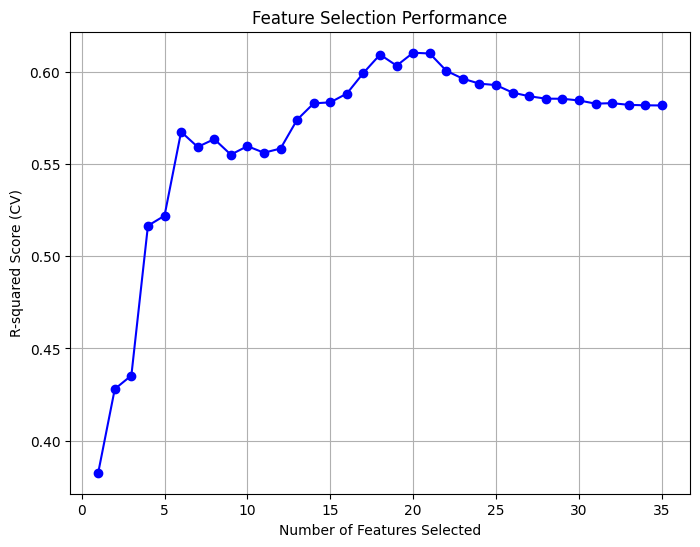

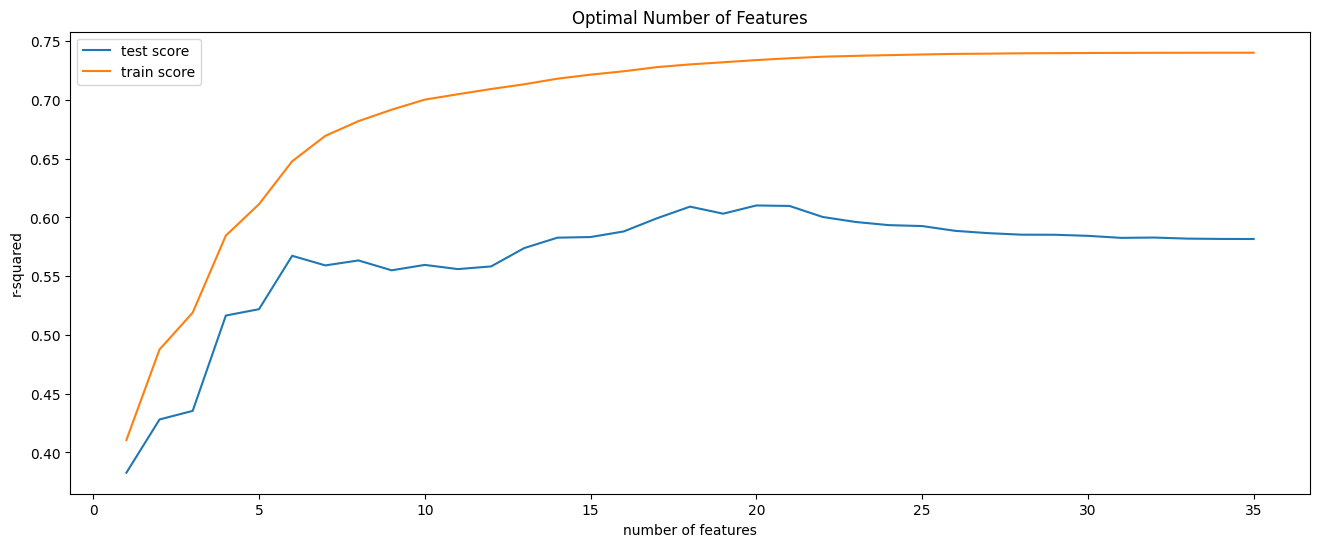

In [ ]:
# Feature Selection Using Cross Validation
#  - The hyperparameter to be tuned is the number of features to select
#  - The model used for feature selection is Linear Regression.
#  - The RFE (Recursive Feature Elimination) wrapper is applied to the linear regression model.
#  - The GridSearchCV algorithm searches through different combinations of features and selects the best subset based on the R-squared ('r2') score.
#  - mean_test_score and mean_train_score represents the average test scores and train scores for a particular no of features(Average of k models generated using cross validation)

colleges = pd.read_csv("colleges_train.csv")

features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug",
            "ug_men",
            "ug_white", "ug_black", "ug_hispanic", "ug_asian", "ug_25plus", "first_gen", "math_deg",
            "faculty_salary", "engi_deg", "bio_deg", "sci_deg", "human_deg", "psych_deg", "engl_deg", "edu_deg",
            "foreign_lang_deg", "law_deg", "comm_deg", "compsci_deg", "arch_deg", "agri_deg", "hist_deg", "socialsci_deg",
            "health_deg", "business_deg", "ft_faculty_rate", "endowment", "booksupply", "roomboard"]

X = colleges[features]
Y = colleges["tuition"]

scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_stan, Y, test_size=0.2, random_state=42)

folds = KFold(n_splits=7, shuffle=True, random_state=100)

# specify range of hyperparameters to tune, consider all available features
hyper_params = {'n_features_to_select': list(range(1, len(features) + 1))}
lm = LinearRegression()

# GridSearchCV()
model_cv = GridSearchCV(estimator=RFE(lm), param_grid=hyper_params, scoring='r2', cv=folds, verbose=1, return_train_score=True)
model_cv.fit(X_train, y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)

# print the best selected features
print("The best selected features are:")
print(X.columns[model_cv.best_estimator_.support_])

# print(cv_results)

# plots for cv

# Print the best number of features selected
best_n_features = model_cv.best_params_['n_features_to_select']
print(f"Best number of features selected: {best_n_features}")

# R-squared scores vs. number of features plot
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_n_features_to_select'], cv_results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.xlabel("Number of Features Selected")
plt.ylabel("R-squared Score (CV)")
plt.title("Feature Selection Performance")
plt.grid(True)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Epoch 0, Loss: 967044288.0
Epoch 10, Loss: 967041664.0
Epoch 20, Loss: 967039104.0
Epoch 30, Loss: 967036544.0
Epoch 40, Loss: 967034048.0
Epoch 50, Loss: 967031488.0
Epoch 60, Loss: 967028736.0
Epoch 70, Loss: 967025792.0
Epoch 80, Loss: 967022400.0
Epoch 90, Loss: 967018624.0
Test error: 33856.832, Baseline error: 13319.394


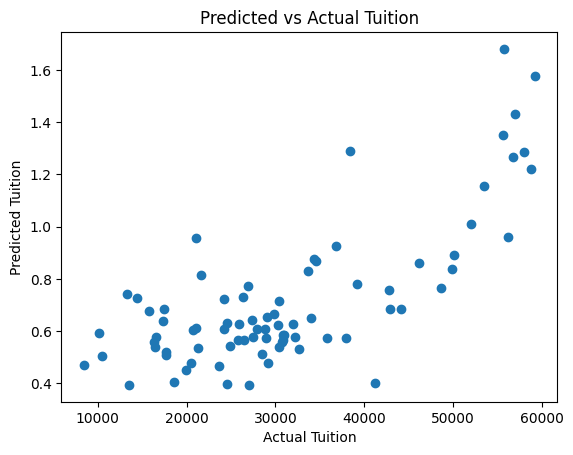

In [ ]:
# Neural Network Model with 1 hidden layer

colleges = pd.read_csv("colleges_train.csv")

# Test error: 33856.093, Baseline error: 13319.394
features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug",
            "ug_white", "ug_black", "ug_hispanic", "ug_asian", "ug_25plus", "first_gen", "math_deg",
            "faculty_salary", "engi_deg", "bio_deg", "sci_deg", "human_deg", "psych_deg", "engl_deg", "edu_deg",
            "foreign_lang_deg", "law_deg", "comm_deg", "compsci_deg", "arch_deg", "agri_deg", "hist_deg", "socialsci_deg",
            "health_deg", "business_deg", "ft_faculty_rate", "endowment", "booksupply", "roomboard"]

# Test error: 33856.942, Baseline error: 13319.394
# features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_men", "ug_white", "ug_black", "ug_hispanic", "ug_25plus",
#            "human_deg", "engl_deg", "edu_deg", "foreign_lang_deg", "law_deg", "compsci_deg", "socialsci_deg", "ft_faculty_rate",
#            "endowment", "roomboard"]

X = colleges[features]
Y = colleges["tuition"]

scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_stan, Y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Define the Neural Network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 5)
        self.fc2 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
# Reshape the y_train_tensor and y_test arrays to be 1-dimensional
y_train_tensor = y_train_tensor.flatten()
y_test = y_test.values.flatten()

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.flatten(), y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Make predictions on the test set
y_pred = model(X_test_tensor).detach().numpy().flatten()

test_error = np.sqrt(np.mean((y_test - y_pred) ** 2))
baseline_error = np.sqrt(np.mean((y_test - y_train.mean()) ** 2))

print(f"Test error: {test_error:.3f}, Baseline error: {baseline_error:.3f}")

# Predicted vs actual tuition plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Tuition")
plt.ylabel("Predicted Tuition")
plt.title("Predicted vs Actual Tuition")
plt.show()

In [ ]:
# Neural Network Model with 1 hidden layer - With cross-validation

colleges = pd.read_csv("colleges_train.csv")

# Test error RMSE: 30997.867 Baseline error: 11743.666
features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug",
            "ug_white", "ug_black", "ug_hispanic", "ug_asian", "ug_25plus", "first_gen", "math_deg",
            "faculty_salary", "engi_deg", "bio_deg", "sci_deg", "human_deg", "psych_deg", "engl_deg", "edu_deg",
            "foreign_lang_deg", "law_deg", "comm_deg", "compsci_deg", "arch_deg", "agri_deg", "hist_deg", "socialsci_deg",
            "health_deg", "business_deg", "ft_faculty_rate", "endowment", "booksupply", "roomboard"]

# Test error RMSE: 31007.193 Baseline error: 11743.666
# features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_men", "ug_white", "ug_black", "ug_hispanic", "ug_25plus",
#           "human_deg", "engl_deg", "edu_deg", "foreign_lang_deg", "law_deg", "compsci_deg", "socialsci_deg", "ft_faculty_rate",
#            "endowment", "roomboard"]

X = colleges[features]
Y = colleges["tuition"]

scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X_stan, dtype=torch.float32)
y_tensor = torch.tensor(Y.values, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cross-validation with k-folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

test_errors = []

for train_index, test_index in kf.split(X_stan):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.flatten(), y_train)
        loss.backward()
        optimizer.step()

    y_pred = model(X_test).detach().numpy().flatten()

    test_error = np.sqrt(np.mean((y_test.numpy().flatten() - y_pred) ** 2))
    test_errors.append(test_error)

# Calculate the average test error across all folds
average_test_error = np.mean(test_errors)

print(f"Average test error: {average_test_error:.3f}")

test_error = np.sqrt(((y_test - y_pred) ** 2).mean())
base_error = np.sqrt(((y_test - y_train.mean()) ** 2).mean())

print(f"Test error RMSE: {test_error:.3f} Baseline error: {base_error:.3f}")

Average test error: 31640.152
Test error RMSE: 31009.984 Baseline error: 11743.666


In [ ]:
# Neural Network Model with 1 hidden layer - With regularization & cross-validation

l2_lambda = 0.01  # regularization parameter

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_lambda)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

test_errors = []

for train_index, test_index in kf.split(X_stan):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.flatten(), y_train)

        # Add L2 regularization term
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)

        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()

    y_pred = model(X_test).detach().numpy().flatten()

    test_error = np.sqrt(np.mean((y_test.numpy().flatten() - y_pred) ** 2))
    test_errors.append(test_error)

average_test_error = np.mean(test_errors)

print(f"Average test error: {average_test_error:.3f}")

test_error = np.sqrt(((y_test - y_pred) ** 2).mean())
base_error = np.sqrt(((y_test - y_train.mean()) ** 2).mean())

print(f"Test error RMSE: {test_error:.3f} Baseline error: {base_error:.3f}")


Average test error: 31611.324
Test error RMSE: 30972.600 Baseline error: 11743.666


Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
RMSE: 5869.857
Average RMSE: 5845.032501156274
Average Training RMSE: 2184.9577925605968
Fold 1 RMSE: 5801.55685677852
Fold 2 RMSE: 5936.021974272159
Fold 3 RMSE: 5538.396898347527
Fold 4 RMSE: 6554.589744046276
Fold 5 RMSE: 5618.494330317265
Fold 6 RMSE: 5549.139695712468
Fold 7 RMSE: 5917.028008619696
Fold 1 Training RMSE: 2205.160746269457
Fold 2 Training RMSE: 2151.5218218018726
Fold 3 Training RMSE: 2192.3464284542556
Fold 4 Training RMSE: 2195.235608933585
Fold 5 Training RMSE: 2179.609805123636
Fold 6 Training RMSE: 2161.672724195451
Fold 7 Training RMSE: 2209.1574131459224
Baseline RMSE: 11227.977763303768


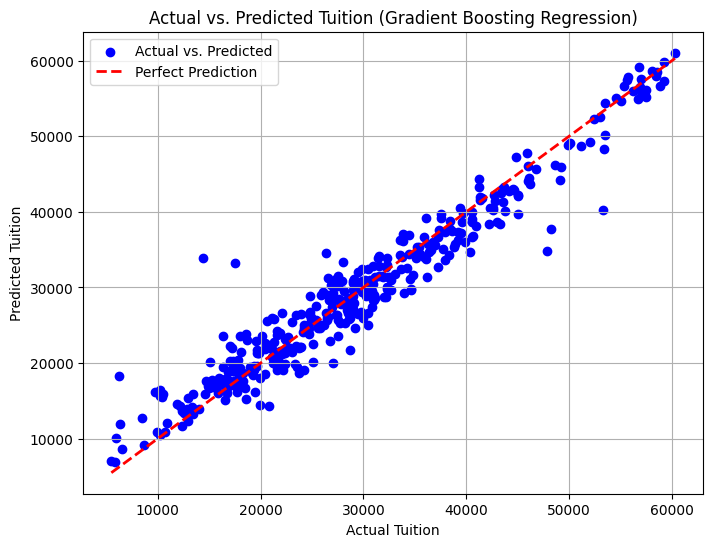

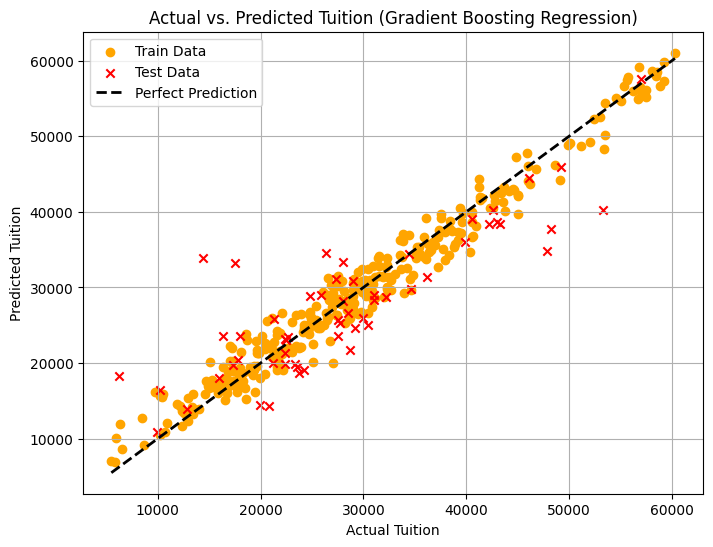

In [ ]:
# Gradient Boosting Model with Cross Validation - version1

colleges = pd.read_csv("colleges_train.csv")

# features = ["satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_asian", "ug_25plus", "roomboard", "endowment", "faculty_salary"]

# features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "ug_men", "ug_white", "ug_black", "ug_hispanic", "ug_25plus",
#            "human_deg", "engl_deg", "edu_deg", "foreign_lang_deg", "law_deg", "compsci_deg", "socialsci_deg", "ft_faculty_rate",
#            "endowment", "roomboard"]

# features = ['adm_rate', 'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
#            'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
#            'faculty_salary', 'human_deg', 'engl_deg', 'edu_deg',
#            'foreign_lang_deg', 'law_deg', 'compsci_deg', 'hist_deg',
#            'socialsci_deg', 'ft_faculty_rate', 'endowment', 'roomboard']

features = ['adm_rate', 'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
            'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
            'faculty_salary', 'human_deg', 'engl_deg', 'edu_deg',
            'compsci_deg', 'socialsci_deg', 'ft_faculty_rate', 'endowment', 'roomboard']

X = colleges[features]
y = colleges["tuition"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Initialize the Gradient Boosting Regression model
gb_regressor = GradientBoostingRegressor(random_state=1)

# Define the parameter grid for cross-validation
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [1, 2, 3, 4]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=7)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_gb_regressor = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

gb_regressor = GradientBoostingRegressor(learning_rate=0.1,
                                n_estimators=300,
                                max_depth = 2,
                                random_state = 1, max_features=7)

gb_regressor.fit(X_train, y_train)

y_pred = gb_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.3f}")

# Perform k-fold cross-validation
k = 7
kf = KFold(n_splits=k, shuffle=True, random_state=1)

rmse_scores = []
train_rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    gb_regressor.fit(X_train, y_train)

    y_pred = gb_regressor.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    y_train_pred = gb_regressor.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_scores.append(train_rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
average_train_rmse = np.mean(train_rmse_scores)

print(f"Average RMSE: {average_rmse}")
print(f"Average Training RMSE: {average_train_rmse}")

# Calculate the RMSE per fold
for i, rmse in enumerate(rmse_scores):
    print(f"Fold {i+1} RMSE: {rmse}")

# Calculate the training RMSE per fold
for i, rmse in enumerate(train_rmse_scores):
    print(f"Fold {i+1} Training RMSE: {rmse}")

# calculate the baseline mse
base_error = np.sqrt(((y_test - y_train.mean()) ** 2).mean())
print(f"Baseline RMSE: {base_error}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, gb_regressor.predict(X), color='blue', marker='o', label='Actual vs. Predicted')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition')
plt.title('Actual vs. Predicted Tuition (Gradient Boosting Regression)')
plt.legend()
plt.grid(True)
plt.show()

# Plot of the train data and test data on the same plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, gb_regressor.predict(X_train), color='orange', marker='o', label='Train Data')
plt.scatter(y_test, gb_regressor.predict(X_test), color='red', marker='x', label='Test Data')
plt.plot([min(y), max(y)], [min(y), max(y)], color='black', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition')
plt.title('Actual vs. Predicted Tuition (Gradient Boosting Regression)')
plt.legend()
plt.grid(True)
plt.show()


***Medhasri's code***

In [ ]:
collegeTrain = pd.read_csv("colleges_train.csv")

Coefficients: 
adm_rate: -861.96
satm50: 2015.13
pell_grant_rate: -5494.00
fed_loan_rate: 4182.48
ug: -3287.28
ug_men: -357.75
ug_white: -1660.66
ug_black: -308.95
ug_hispanic: 1085.35
ug_asian: 842.87
ug_25plus: -42.10
first_gen: -1537.20
math_deg: 97.51
faculty_salary: 963.41
engi_deg: -342.02
bio_deg: 213.17
sci_deg: 640.22
human_deg: -400.31
psych_deg: -64.43
engl_deg: -543.52
edu_deg: -1397.39
foreign_lang_deg: 773.98
law_deg: 1604.46
comm_deg: 300.24
compsci_deg: 429.18
arch_deg: 128.20
agri_deg: -7.75
hist_deg: -1472.20
socialsci_deg: 1971.18
health_deg: 570.60
business_deg: 158.64
ft_faculty_rate: 1185.53
endowment: 775.12
booksupply: 281.76
roomboard: 1657.66
Intercept: 28616.91
Test Error: 7220.32
Baseline Error: 12189.93
Test R-squared: 0.65


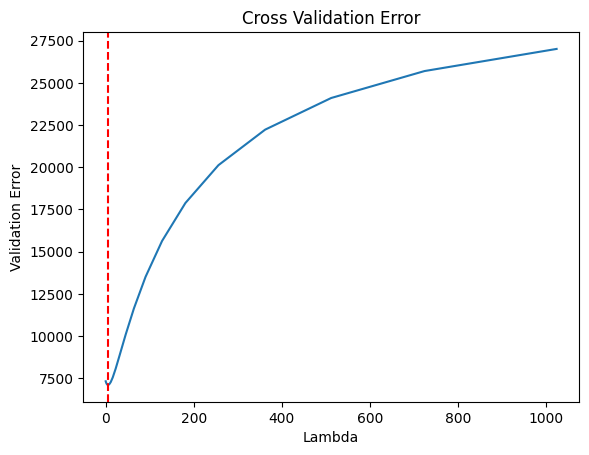

In [ ]:
#using ridge regression to predict tuition
import warnings
warnings.filterwarnings('ignore')

## permute rows of collegeTrain

# List of features, drop ug_men, satv25, satv50, satv75, satm25, satm75
features = ["adm_rate","satm50","pell_grant_rate","fed_loan_rate","ug", "ug_men",
            "ug_white","ug_black","ug_hispanic","ug_asian","ug_25plus","first_gen", "math_deg",
            "faculty_salary","engi_deg","bio_deg","sci_deg","human_deg","psych_deg","engl_deg","edu_deg",
            "foreign_lang_deg","law_deg","comm_deg","compsci_deg","arch_deg","agri_deg","hist_deg","socialsci_deg",
            "health_deg","business_deg","ft_faculty_rate","endowment","booksupply","roomboard"]

# Target variable
Y = collegeTrain['tuition']
X = collegeTrain[features]
X_stan = StandardScaler().fit_transform(X)

# Add a column of ones to include the intercept in the model
X_stan = np.c_[X_stan, np.ones(X_stan.shape[0])]

# Split the data into test, learning (further divided into train and validation), and training sets
n_learn = 400
n_test = 200

Y_test = Y.iloc[:n_test]
Y_learn = Y.iloc[n_test:n_test+n_learn]

X_test = X_stan[:n_test, :]
X_learn = X_stan[n_test:n_test+n_learn, :]

# Candidate set for lambda
candidate_set = np.concatenate([[0], 2 ** np.arange(0, 10.5, 0.5)])

K = 10
folds = KFold(n_splits=K)

validerr = np.zeros((K, len(candidate_set)))

for k, (train_index, valid_index) in enumerate(folds.split(X_learn)):
    X_train, X_valid = X_learn[train_index], X_learn[valid_index]
    Y_train, Y_valid = Y_learn.iloc[train_index], Y_learn.iloc[valid_index]


    for j, lambda_val in enumerate(candidate_set):
      beta_lambda = inv(X_train.T @ X_train + lambda_val * np.eye(X_train.shape[1])) @ X_train.T @ Y_train
      Y_lambda = X_valid @ beta_lambda
      validerr[k, j] = np.sqrt(np.mean((Y_valid - Y_lambda) ** 2))

mean_valid_errs = validerr.mean(axis=0)
min_ix = np.argmin(mean_valid_errs)

lambda_best = candidate_set[min_ix]

beta_best = solve(X_learn.T @ X_learn + lambda_best * np.eye(X_learn.shape[1]), X_learn.T @ Y_learn)

Y_pred = X_test @ beta_best
Y_baseline = Y_learn.mean()

# print coefficients
print("Coefficients: ")
for i in range(len(features)):
    print(f"{features[i]}: {beta_best[i]:.2f}")
print(f"Intercept: {beta_best[-1]:.2f}")

# Evaluate test error
test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
baseline_error = np.sqrt(((Y_test - Y_train.mean()) ** 2).mean())

## print errors and R^2 with 2 sig figs
print("Test Error: {:.2f}".format(test_error))
print("Baseline Error: {:.2f}".format(baseline_error))
print("Test R-squared: {:.2f}".format(1 - test_error ** 2 / baseline_error ** 2))

## plot cross validation errors
import matplotlib.pyplot as plt
plt.plot(candidate_set, mean_valid_errs)
plt.axvline(x=lambda_best, color='r', linestyle='--')
plt.xlabel("Lambda")
plt.ylabel("Validation Error")
plt.title("Cross Validation Error")
plt.show()

In [ ]:
#PCA
#standardizing the data, ( + removing extra features)
features = ["adm_rate","satm50","pell_grant_rate","fed_loan_rate","ug", "ug_men",
            "ug_white","ug_black","ug_hispanic","ug_asian","ug_25plus","first_gen", "math_deg",
            "faculty_salary","engi_deg","bio_deg","sci_deg","human_deg","psych_deg","engl_deg","edu_deg",
            "foreign_lang_deg","law_deg","comm_deg","compsci_deg","arch_deg","agri_deg","hist_deg","socialsci_deg",
            "health_deg","business_deg","ft_faculty_rate","endowment","booksupply","roomboard"]

some_features = ['fed_loan_rate', 'ug_25plus', 'roomboard', 'endowment'] #using the top four features with the elbow method

# Target variable
Y = collegeTrain['tuition']
X = collegeTrain[features]
print(f"Num features: {X.shape[1]}")

X_stan = StandardScaler().fit_transform(X)

pca = PCA(n_components=34) #originally 34
pca.fit(X_stan)
component35=pca.components_
print(pca.components_)
print(pca.explained_variance_)
print("PCA1:" + (str)(pca.components_[0]))

Num features: 35
[[-0.18923507  0.33386394 -0.23601876 ...  0.18576239 -0.0243027
   0.22890723]
 [-0.13471611 -0.06323223  0.29396561 ...  0.06829014  0.11287775
   0.1775785 ]
 [-0.00813313  0.13484247 -0.13946276 ...  0.04147628  0.10841837
   0.04187576]
 ...
 [ 0.04028061 -0.02178994 -0.13789586 ...  0.19784971  0.00489967
   0.10825597]
 [-0.02208067 -0.52046639  0.44824072 ...  0.05240424  0.00527261
   0.15736379]
 [-0.13542499 -0.68172513 -0.5855052  ... -0.01474895 -0.00532594
  -0.09183146]]
[6.97745318 3.23716975 3.04333733 1.88507607 1.48435265 1.41446577
 1.23329704 1.213447   1.10758195 1.02926441 0.9904555  0.97652864
 0.90111956 0.85132033 0.77298952 0.76632551 0.71940701 0.66402021
 0.6130727  0.55421985 0.53743552 0.50730619 0.48645074 0.46132806
 0.42376112 0.41467379 0.37362898 0.31916425 0.27363638 0.243613
 0.198077   0.15497113 0.11264948 0.10573441]
PCA1:[-1.89235067e-01  3.33863942e-01 -2.36018757e-01 -2.28532366e-01
  1.16250672e-01  9.86238153e-02  2.5106158

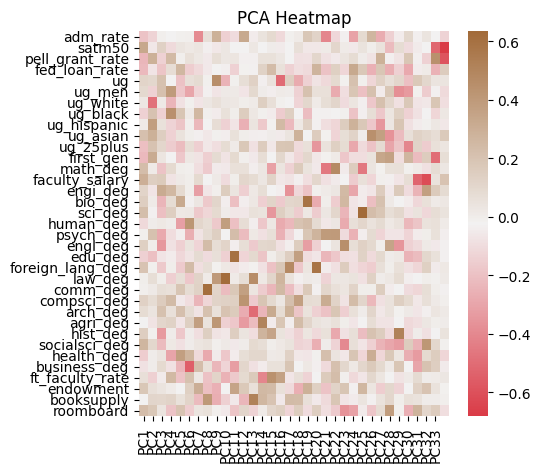

In [ ]:
#displaying the PCA
pcalabel = []
for i in range(1,34): #originally 34
    pcalabel.append('PC'+str(i))
plt.figure(figsize=(5,5))
cmap = sns.diverging_palette(10, 40,as_cmap=True)
sns.heatmap(component35.T, cmap=cmap, yticklabels = features, xticklabels = pcalabel)
plt.title('PCA Heatmap')
plt.show()

#some things to note:
# heatmap shows the relationship between the features principal components extracted through PCA
# Each cell in the heatmap represents the weight of a feature in a principal component

#cross vailidation --> PCA --> then discuss each of our models such as ridge regression, then continue to our final model

In [ ]:
weightSum = pd.DataFrame(abs(pca.components_[:4])).sum(axis=0)

# Rank the features based on their absolute sum of weights
feature_importance = pd.DataFrame({'Feature': features, 'WeightsSum': weightSum})

print(feature_importance.sort_values(by='WeightsSum', ascending=False))

             Feature  WeightsSum
7           ug_black    0.936286
2    pell_grant_rate    0.917824
5             ug_men    0.845694
9           ug_asian    0.788858
14          engi_deg    0.766604
6           ug_white    0.761988
13    faculty_salary    0.687193
10         ug_25plus    0.676552
1             satm50    0.642266
34         roomboard    0.640397
28     socialsci_deg    0.609980
24       compsci_deg    0.609623
16           sci_deg    0.609097
11         first_gen    0.601088
18         psych_deg    0.594423
8        ug_hispanic    0.582277
19          engl_deg    0.570174
3      fed_loan_rate    0.560206
12          math_deg    0.523025
31   ft_faculty_rate    0.512606
27          hist_deg    0.508939
29        health_deg    0.501154
15           bio_deg    0.478977
20           edu_deg    0.464180
4                 ug    0.451572
25          arch_deg    0.395223
21  foreign_lang_deg    0.381198
33        booksupply    0.368126
0           adm_rate    0.353819
26        

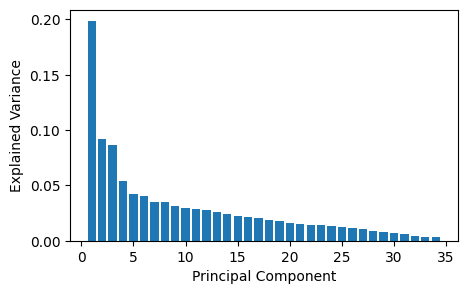

In [ ]:
# Calculate explained variance ratio for each PC
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(5, 3))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

#elbow method -- try to use the point where the curve starts to flatten is often chosen as
#the number of components to retain, as it represents the point where additional components add little explanatory power

In [ ]:
#a combination of PCA and linear regression
X_train, X_test, Y_train, Y_test = train_test_split(X_stan, Y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=34) #originally 34
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train_pca, Y_train)

Y_pred = regression_model.predict(X_test_pca)

rmse = mean_squared_error(Y_test, Y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 6648.8721300963525


***TIRTH's CODE***

Running simulations for column: adm_rate
Correlation from data:
-0.37504510717510675
Bootstrap standard deviation: 0.057363947881724574
Bootstrap 95% confidence interval: (-0.4897730029385559, -0.2603172114116576)


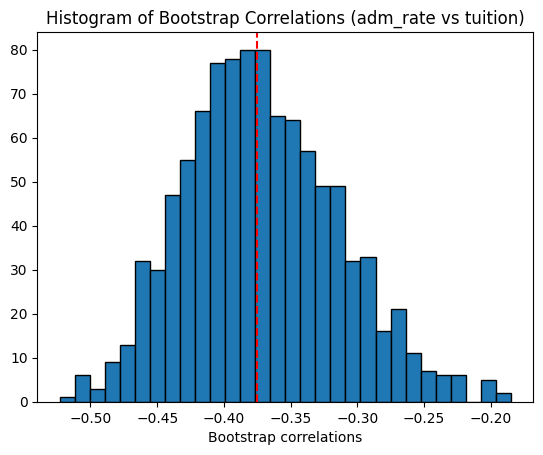

Running simulations for column: satm50
Correlation from data:
0.6758235607017101
Bootstrap standard deviation: 0.034634333535051964
Bootstrap 95% confidence interval: (0.6065548936316062, 0.745092227771814)


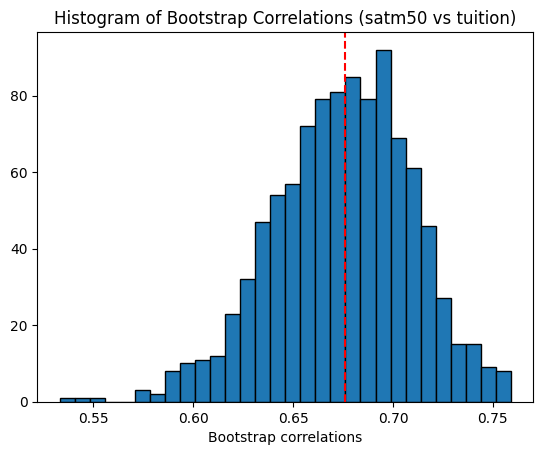

Running simulations for column: pell_grant_rate
Correlation from data:
-0.5738018089213698
Bootstrap standard deviation: 0.03344253728832623
Bootstrap 95% confidence interval: (-0.6406868834980223, -0.5069167343447173)


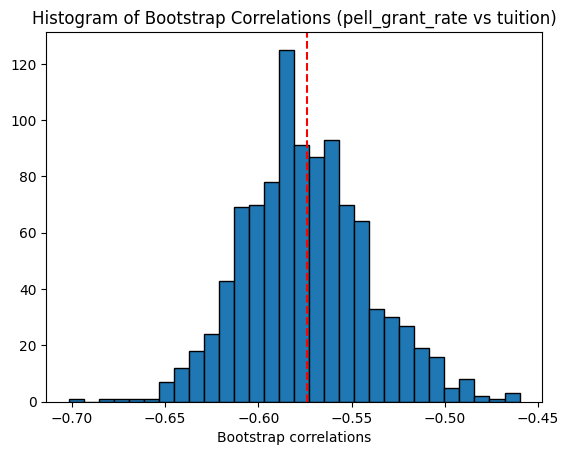

Running simulations for column: fed_loan_rate
Correlation from data:
-0.17705339227559597
Bootstrap standard deviation: 0.0575264642610824
Bootstrap 95% confidence interval: (-0.2921063207977608, -0.06200046375343117)


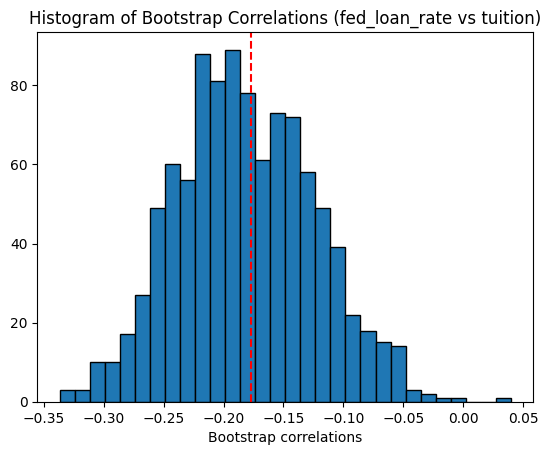

Running simulations for column: ug
Correlation from data:
-0.050170551845548354
Bootstrap standard deviation: 0.041439152300551396
Bootstrap 95% confidence interval: (-0.13304885644665115, 0.03270775275555444)


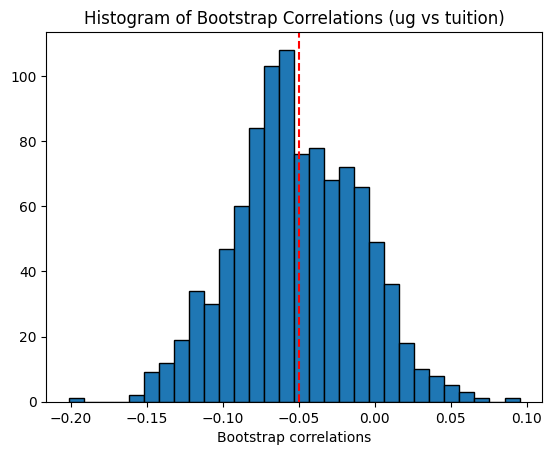

Running simulations for column: ug_men
Correlation from data:
0.05234118810421253
Bootstrap standard deviation: 0.04560027839427717
Bootstrap 95% confidence interval: (-0.038859368684341804, 0.14354174489276686)


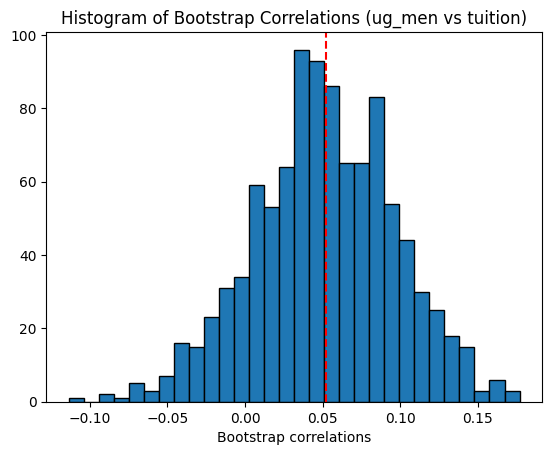

Running simulations for column: ug_women
Correlation from data:
-0.05234118810421253
Bootstrap standard deviation: 0.045907559530411673
Bootstrap 95% confidence interval: (-0.14415630716503589, 0.039473930956610816)


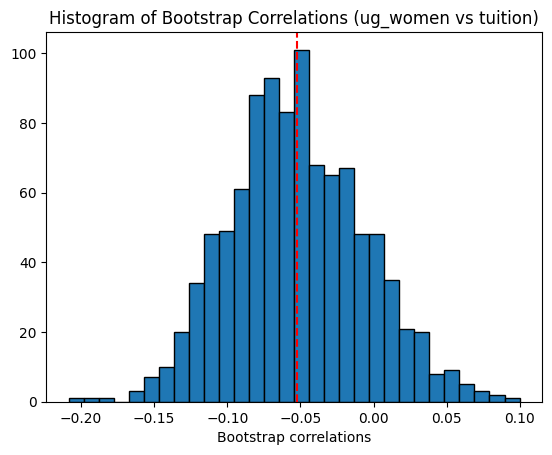

Running simulations for column: ug_white
Correlation from data:
0.07146742081958765
Bootstrap standard deviation: 0.04583864869906113
Bootstrap 95% confidence interval: (-0.02020987657853461, 0.16314471821770993)


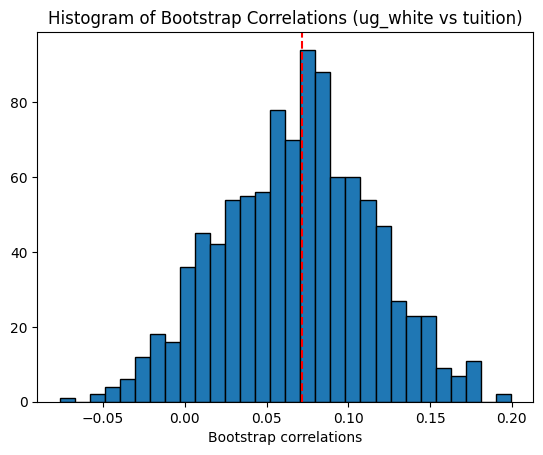

Running simulations for column: ug_black
Correlation from data:
-0.33261456388504307
Bootstrap standard deviation: 0.02951731576407808
Bootstrap 95% confidence interval: (-0.3916491954131992, -0.27357993235688693)


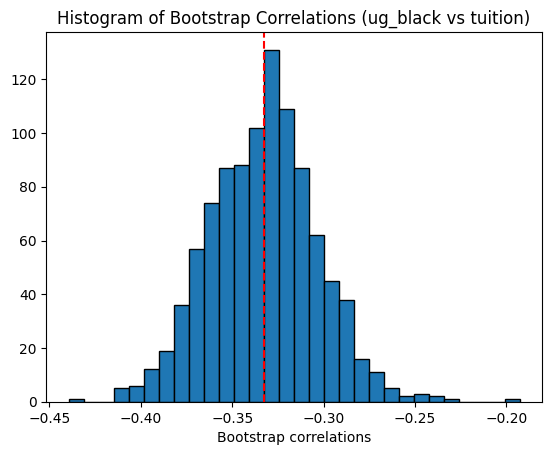

Running simulations for column: ug_hispanic
Correlation from data:
0.04522979085864144
Bootstrap standard deviation: 0.04263507857699101
Bootstrap 95% confidence interval: (-0.04004036629534058, 0.13049994801262346)


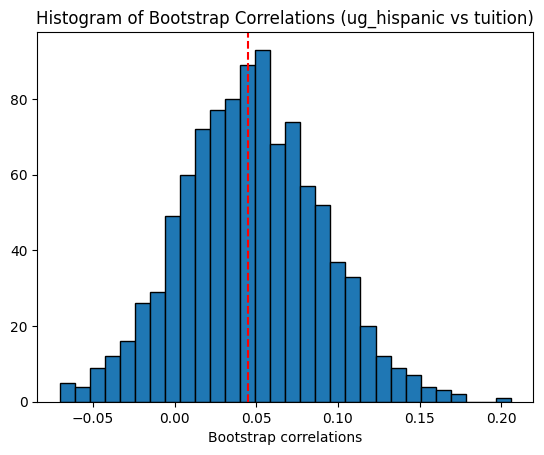

Running simulations for column: ug_asian
Correlation from data:
0.3829892036686799
Bootstrap standard deviation: 0.05648612747320853
Bootstrap 95% confidence interval: (0.27001694872226284, 0.49596145861509694)


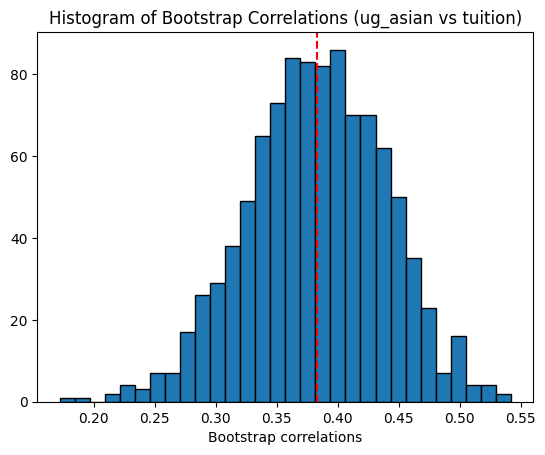

Running simulations for column: ug_25plus
Correlation from data:
-0.3954752555817938
Bootstrap standard deviation: 0.03435334247032511
Bootstrap 95% confidence interval: (-0.464181940522444, -0.3267685706411436)


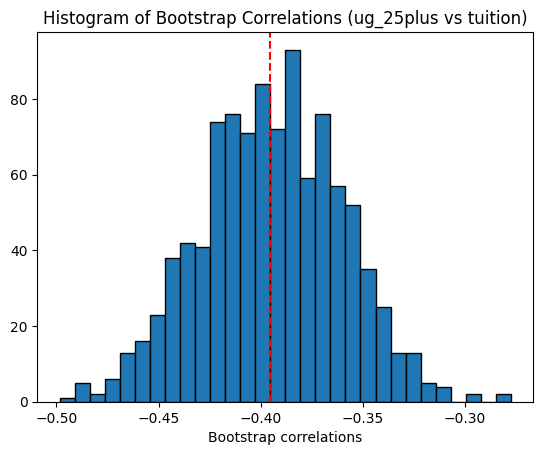

Running simulations for column: first_gen
Correlation from data:
-0.5104670191675278
Bootstrap standard deviation: 0.042372163010942654
Bootstrap 95% confidence interval: (-0.5952113451894131, -0.4257226931456425)


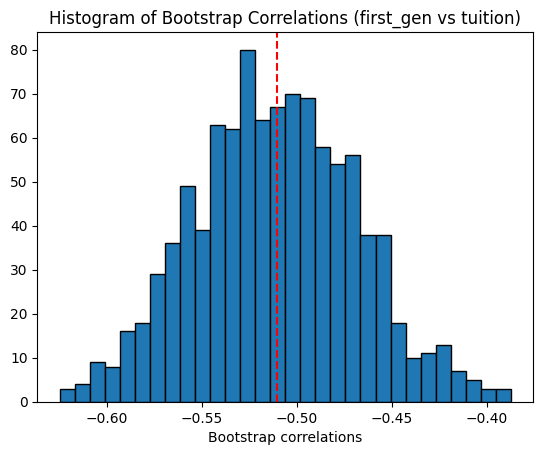

Running simulations for column: math_deg
Correlation from data:
0.3984506269427718
Bootstrap standard deviation: 0.04749047676468971
Bootstrap 95% confidence interval: (0.30346967341339237, 0.4934315804721512)


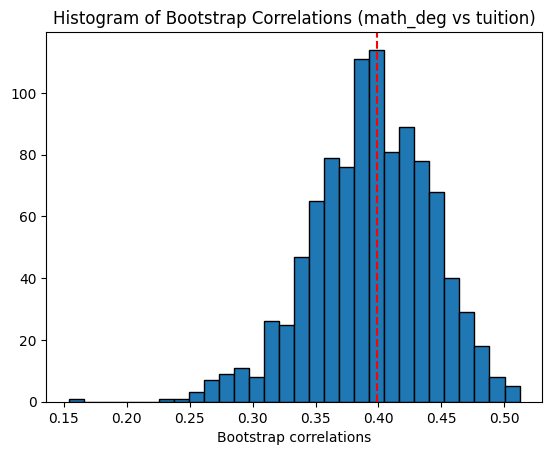

Running simulations for column: faculty_salary
Correlation from data:
0.526310002379526
Bootstrap standard deviation: 0.039864970657234385
Bootstrap 95% confidence interval: (0.4465800610650572, 0.6060399436939947)


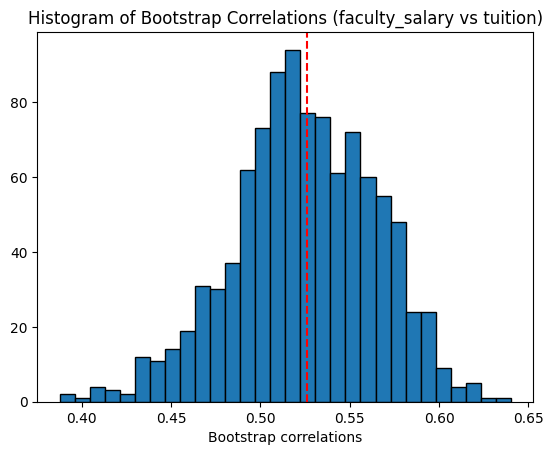

Running simulations for column: engi_deg
Correlation from data:
0.14503428425288709
Bootstrap standard deviation: 0.0517240436318866
Bootstrap 95% confidence interval: (0.04158619698911388, 0.2484823715166603)


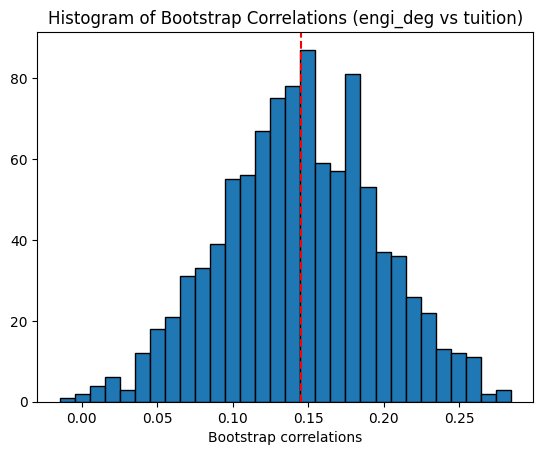

Running simulations for column: bio_deg
Correlation from data:
0.3053998273656132
Bootstrap standard deviation: 0.056275146122699474
Bootstrap 95% confidence interval: (0.19284953512021427, 0.41795011961101214)


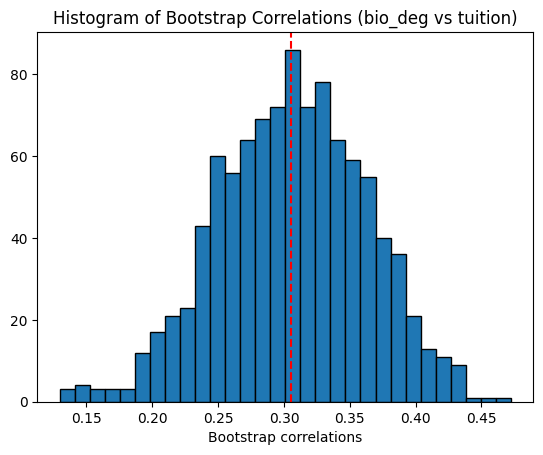

Running simulations for column: sci_deg
Correlation from data:
0.34677675141019354
Bootstrap standard deviation: 0.05645983969119125
Bootstrap 95% confidence interval: (0.23385707202781103, 0.45969643079257605)


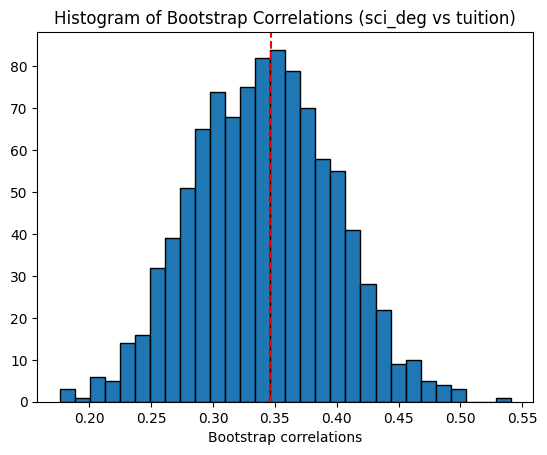

Running simulations for column: human_deg
Correlation from data:
-0.2997927834813423
Bootstrap standard deviation: 0.03231111370162083
Bootstrap 95% confidence interval: (-0.36441501088458395, -0.23517055607810064)


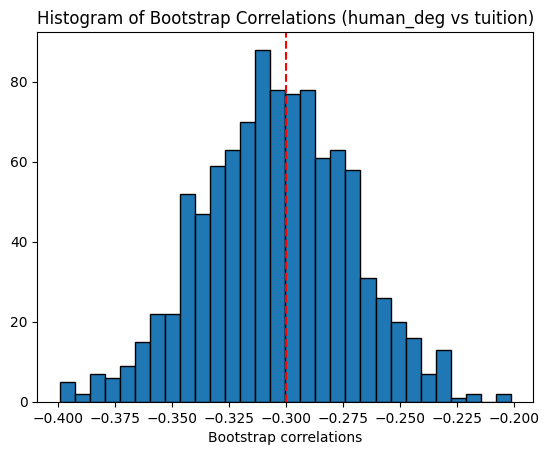

Running simulations for column: psych_deg
Correlation from data:
-0.005251095259638724
Bootstrap standard deviation: 0.04811423048753005
Bootstrap 95% confidence interval: (-0.10147955623469883, 0.09097736571542138)


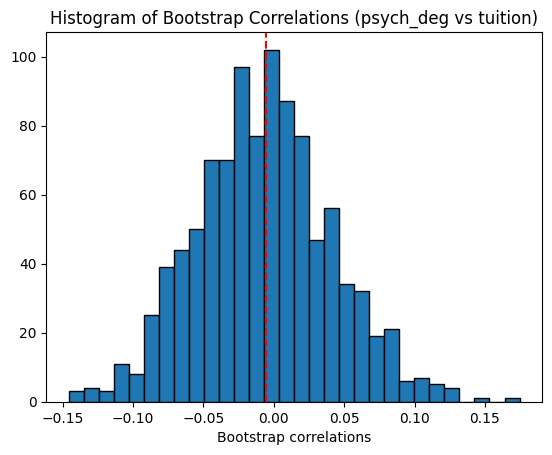

Running simulations for column: engl_deg
Correlation from data:
0.17914638336265828
Bootstrap standard deviation: 0.04895365544708905
Bootstrap 95% confidence interval: (0.08123907246848018, 0.2770536942568364)


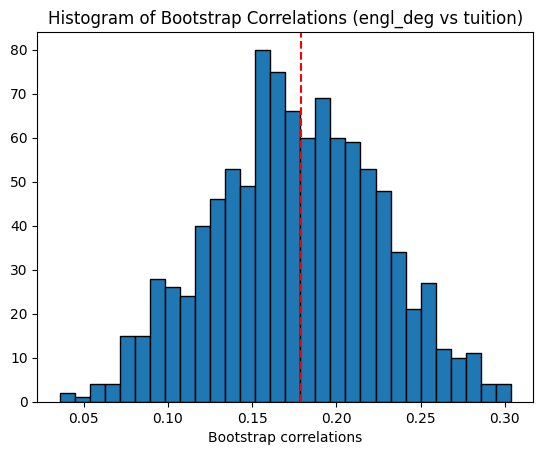

Running simulations for column: edu_deg
Correlation from data:
-0.3196543945273927
Bootstrap standard deviation: 0.03599522608565938
Bootstrap 95% confidence interval: (-0.39164484669871147, -0.24766394235607392)


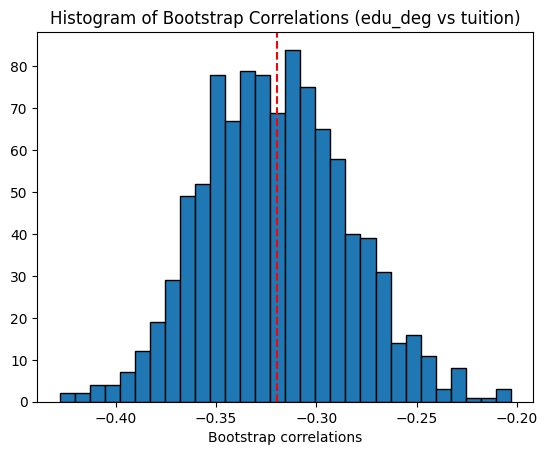

Running simulations for column: foreign_lang_deg
Correlation from data:
0.302113789236376
Bootstrap standard deviation: 0.07171201898970854
Bootstrap 95% confidence interval: (0.15868975125695892, 0.44553782721579305)


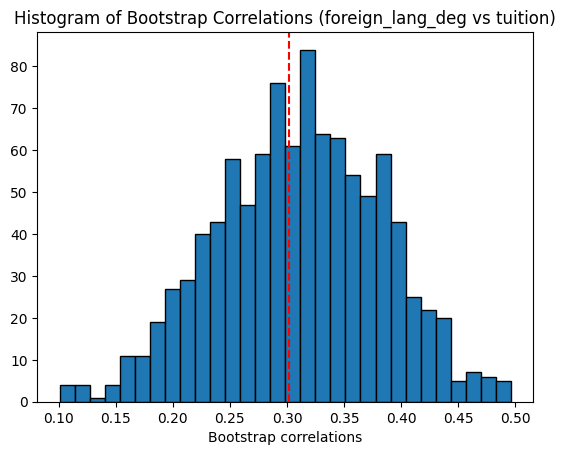

Running simulations for column: law_deg
Correlation from data:
0.047603733845944074
Bootstrap standard deviation: 0.04297584360656114
Bootstrap 95% confidence interval: (-0.03834795336717821, 0.13355542105906637)


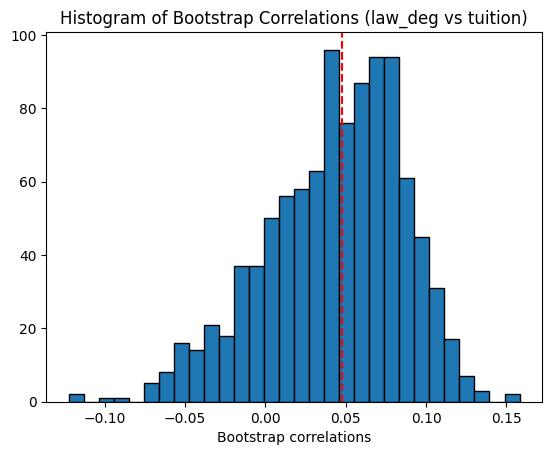

Running simulations for column: comm_deg
Correlation from data:
-0.01079983306516406
Bootstrap standard deviation: 0.04368235184177263
Bootstrap 95% confidence interval: (-0.09816453674870933, 0.0765648706183812)


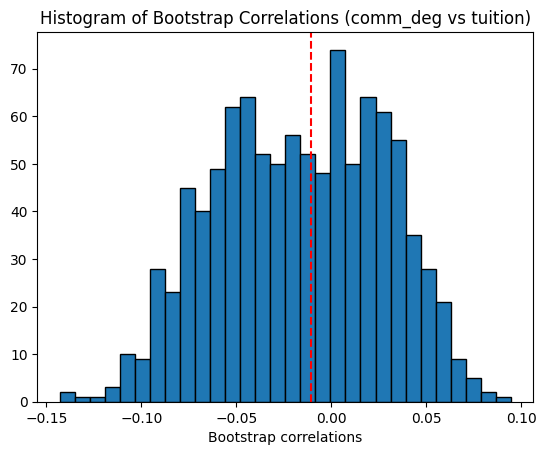

Running simulations for column: compsci_deg
Correlation from data:
0.17700202067891269
Bootstrap standard deviation: 0.04371956349557859
Bootstrap 95% confidence interval: (0.08956289368775551, 0.2644411476700699)


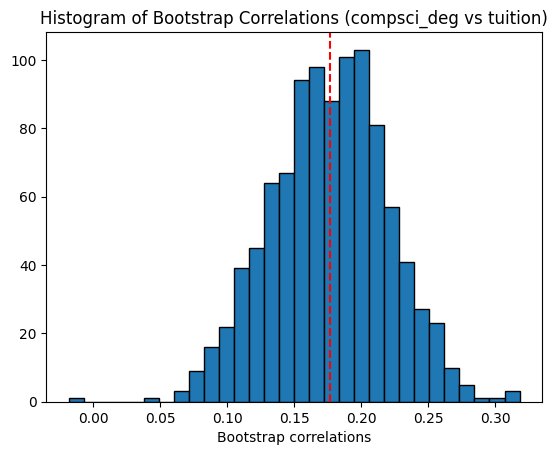

Running simulations for column: arch_deg
Correlation from data:
0.1294958408608649
Bootstrap standard deviation: 0.040602579946873184
Bootstrap 95% confidence interval: (0.04829068096711854, 0.2107010007546113)


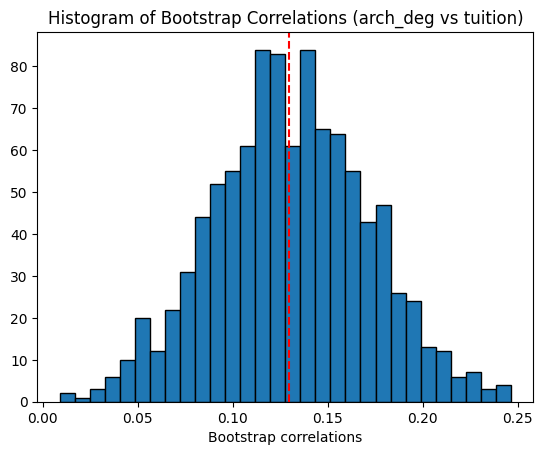

Running simulations for column: agri_deg
Correlation from data:
-0.11702011633308133
Bootstrap standard deviation: 0.030034410032216054
Bootstrap 95% confidence interval: (-0.17708893639751344, -0.056951296268649226)


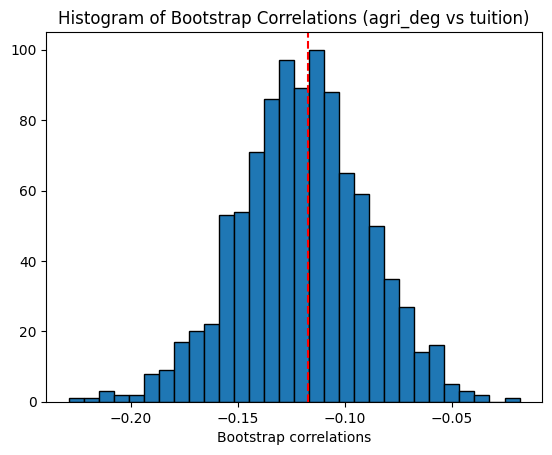

Running simulations for column: hist_deg
Correlation from data:
0.19420668614725808
Bootstrap standard deviation: 0.05947425047371232
Bootstrap 95% confidence interval: (0.07525818519983345, 0.3131551870946827)


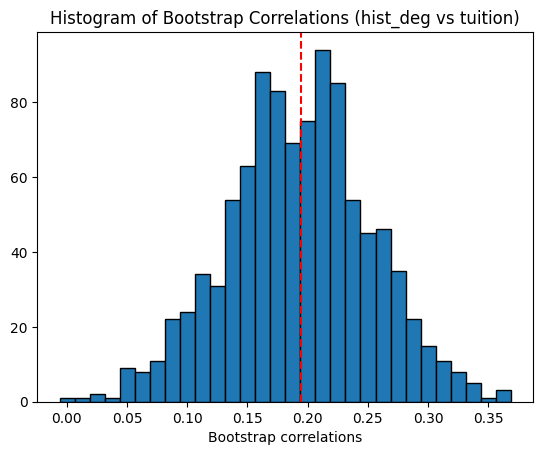

Running simulations for column: socialsci_deg
Correlation from data:
0.4783976769836826
Bootstrap standard deviation: 0.05235121341214422
Bootstrap 95% confidence interval: (0.37369525015939414, 0.5831001038079711)


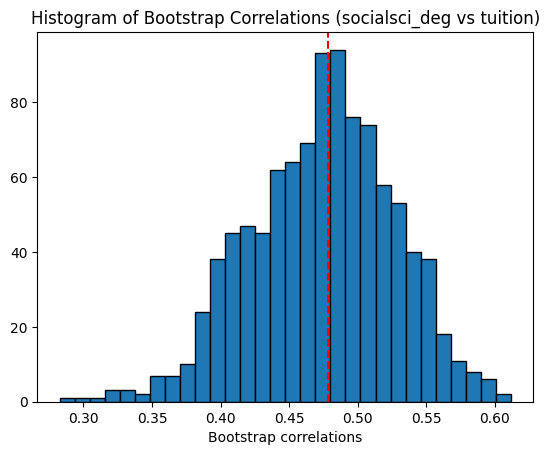

Running simulations for column: health_deg
Correlation from data:
-0.09968544778823842
Bootstrap standard deviation: 0.04302342769912025
Bootstrap 95% confidence interval: (-0.18573230318647893, -0.013638592389997914)


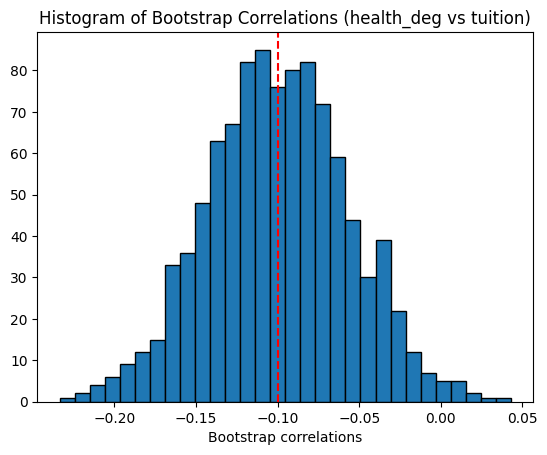

Running simulations for column: business_deg
Correlation from data:
-0.021225580036849916
Bootstrap standard deviation: 0.06820822693320151
Bootstrap 95% confidence interval: (-0.15764203390325293, 0.1151908738295531)


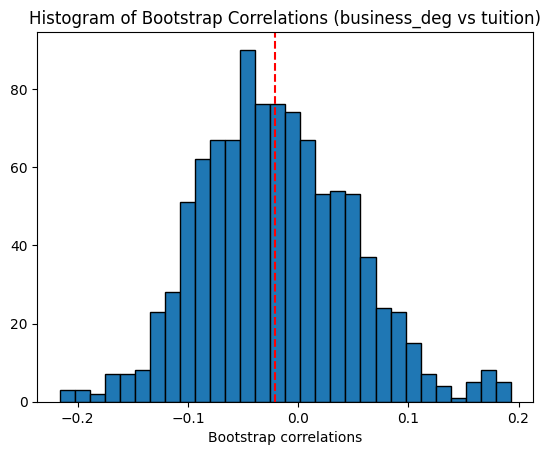

Running simulations for column: ft_faculty_rate
Correlation from data:
0.0937894001835563
Bootstrap standard deviation: 0.040667203982812324
Bootstrap 95% confidence interval: (0.012454992217931657, 0.17512380814918094)


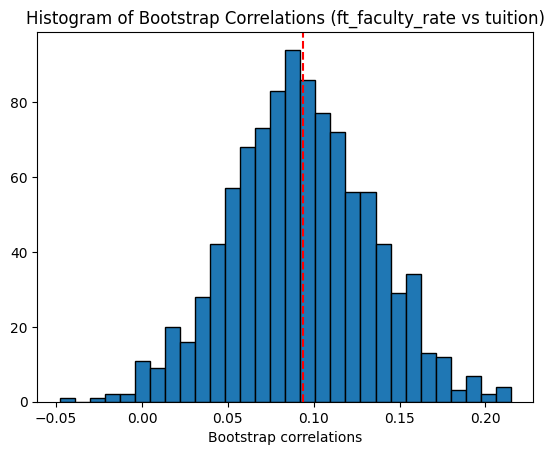

Running simulations for column: endowment
Correlation from data:
0.32580840822509916
Bootstrap standard deviation: 0.03877125099046275
Bootstrap 95% confidence interval: (0.24826590624417366, 0.40335091020602465)


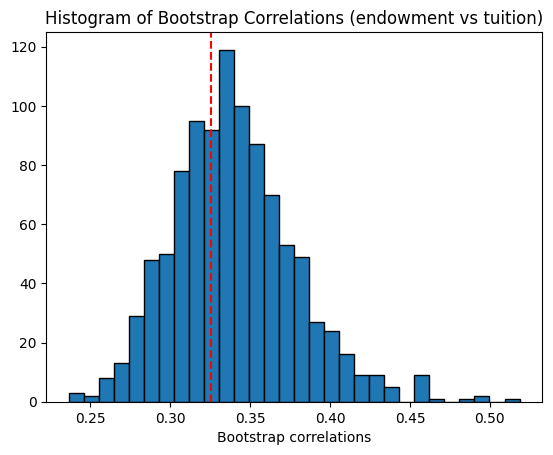

Running simulations for column: booksupply
Correlation from data:
-0.03924378075873008
Bootstrap standard deviation: 0.045753201163096044
Bootstrap 95% confidence interval: (-0.13075018308492217, 0.05226262156746201)


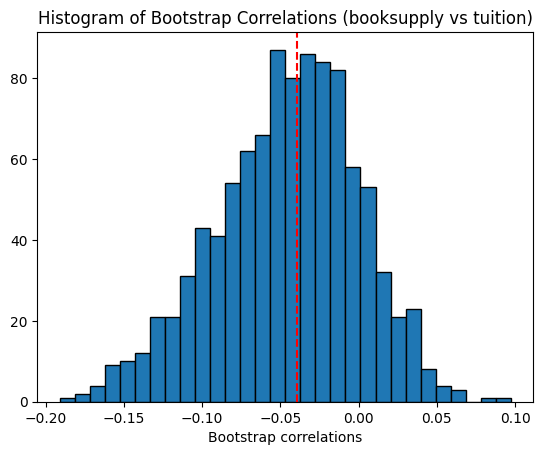

Running simulations for column: roomboard
Correlation from data:
0.5717103784037432
Bootstrap standard deviation: 0.046307473228165696
Bootstrap 95% confidence interval: (0.4790954319474118, 0.6643253248600746)


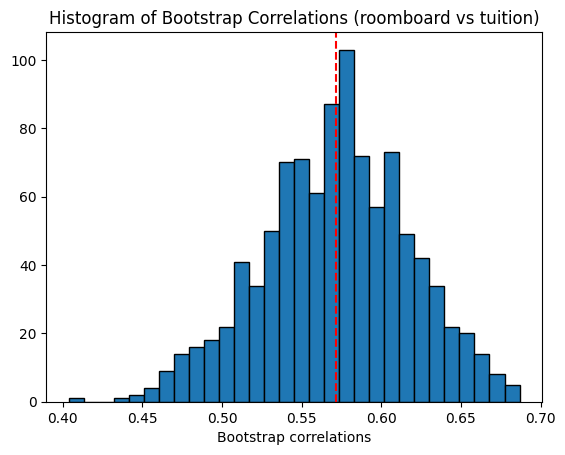

Column: satm50, Correlation: 0.6758235607017101, Standard Deviation: 0.034634333535051964
Column: pell_grant_rate, Correlation: -0.5738018089213698, Standard Deviation: 0.03344253728832623
Column: first_gen, Correlation: -0.5104670191675278, Standard Deviation: 0.042372163010942654
Column: faculty_salary, Correlation: 0.526310002379526, Standard Deviation: 0.039864970657234385
Column: roomboard, Correlation: 0.5717103784037432, Standard Deviation: 0.046307473228165696


In [ ]:
# Load the data
clg = pd.read_csv("colleges_train.csv")

# Get all column names except 'tuition'
cols=['tuition','state','name','satv25','satv50','satv75','satm25','satm75']
columns = clg.columns.drop(cols)
#columns=house.columns.drop('tuition')
high_corr = 0.5  # Define your threshold for high correlation here
n_sim = 1000

# Dictionary to store columns with high correlation and low standard deviation
best_predictors = {}

# For each column
for column in columns:
    print(f"Running simulations for column: {column}")

    X = clg[['tuition', column]].dropna().values
    n = len(X)

    obs_corr = np.corrcoef(X[:, 0], X[:, 1])[0, 1]
    print("Correlation from data:")
    print(obs_corr)

    all_corrs = np.zeros(n_sim)

    # Perform bootstrap simulations
    for cur_sim in range(n_sim):
        indices = np.random.choice(range(n), n, replace=True)
        Xboot = X[indices]
        all_corrs[cur_sim] = np.corrcoef(Xboot[:, 0], Xboot[:, 1])[0, 1]

    std_dev = np.std(all_corrs)
    print(f"Bootstrap standard deviation: {std_dev}")
    print(f"Bootstrap 95% confidence interval: {(obs_corr - 2*std_dev, obs_corr + 2*std_dev)}")

    # If this column's correlation is high and standard deviation is low, add it to best_predictors
    if abs(obs_corr) > high_corr:
        best_predictors[column] = {'correlation': obs_corr, 'std_dev': std_dev}

    plt.hist(all_corrs, bins=30, edgecolor='black')
    plt.xlabel('Bootstrap correlations')
    plt.title(f'Histogram of Bootstrap Correlations ({column} vs tuition)')
    plt.axvline(x=obs_corr, color='r', linestyle='--')
    plt.show()

# Print the best predictors for 'tuition'
for column, stats in best_predictors.items():
    print(f"Column: {column}, Correlation: {stats['correlation']}, Standard Deviation: {stats['std_dev']}")

In [ ]:
from numpy.linalg import lstsq

# Read CSV file
clg_split = pd.read_csv("colleges_train.csv")

# Shuffle the DataFrame
np.random.seed(0)
clg_split = clg_split.sample(frac=1).reset_index(drop=True)

# Select featuresp
# Reorder the columns
cols = ['high_tuition'] + [col for col in clg_split if col != 'high_tuition']
clg_split = clg_split.reindex(columns=cols)

# Now, 'high_tuition' is the first column

clg_split["high_tuition"] = (clg_split["tuition"] > clg_split["tuition"].quantile(0.75)).astype(int)
# Select features
Y = clg_split['tuition'].values
features = ["high_tuition", "satm50", "pell_grant_rate", "first_gen", "faculty_salary", "roomboard"]
#features = ["high_tuition", "satm50", "pell_grant_rate", "fed_loan_rate", "ug", "first_gen", "faculty_salary", "ug_white", "socialsci_deg", "roomboard"]
X = clg_split[features].values
st=StandardScaler()
X=st.fit_transform(X)
# Add a column of ones to X
n = len(X)
p = X.shape[1]
X = np.hstack((X, np.ones((n, 1))))

# Split data into learning and test sets
X_learn, X_test, Y_learn, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test
n_learn=len(X_learn)
n_test=len(X_test)


K = 10
folds = np.array_split(range(n_learn), K)

validerr = np.zeros((K, 2))

# Add a small regularization term to the diagonal elements of the matrix
reg_term = 1e-6

for k in range(K):
    valid_ix = folds[k]
    if n_learn < K:
        raise ValueError(f"Number of learning samples ({n_learn}) must be greater than or equal to the number of folds ({K})")
    train_ix = np.setdiff1d(range(n_learn), folds[k])

    X_valid = X_learn[valid_ix, :]
    X_train = X_learn[train_ix, :]

    Y_valid = Y_learn[valid_ix]
    Y_train = Y_learn[train_ix]

    # Fit two separate linear regression models
    idx = X_train[:, 0] == 1  # Assuming first column is "big_budget" indicator

    X_train1 = X_train[idx, 1:]
    X_train2 = X_train[~idx, 1:]

    Y_train1 = Y_train[idx]
    Y_train2 = Y_train[~idx]

    beta1, _, _, _ = lstsq(X_train1.T @ X_train1 + reg_term * np.eye(X_train1.shape[1]), X_train1.T @ Y_train1, rcond=None)
    beta2, _, _, _ = lstsq(X_train2.T @ X_train2 + reg_term * np.eye(X_train2.shape[1]), X_train2.T @ Y_train2, rcond=None)

    idx_valid = X_valid[:, 0] == 1

    X_valid1 = X_valid[idx_valid, 1:]
    X_valid2 = X_valid[~idx_valid, 1:]

    Y_pred = np.zeros(len(Y_valid))

    Y_pred[idx_valid] = X_valid1 @ beta1
    Y_pred[~idx_valid] = X_valid2 @ beta2

    validerr[k, 0] = np.mean((Y_pred - Y_valid) ** 2)

    # Fit one linear regression model on all the data
    beta_all, _, _, _ = lstsq(X_train.T @ X_train + reg_term * np.eye(X_train.shape[1]), X_train.T @ Y_train, rcond=None)
    Y_pred2 = X_valid @ beta_all

    validerr[k, 1] = np.mean((Y_pred2 - Y_valid) ** 2)

mean_validerr = validerr.mean(axis=0)

print(f"Mean validation error for separated models: {mean_validerr[0]:.3f}")
print(f"Mean validation error for combined model: {mean_validerr[1]:.3f}")

Mean validation error for separated models: 64811938.778
Mean validation error for combined model: 39674140.900


In [ ]:
## Fit final model

if (mean_validerr[0] < mean_validerr[1]):

    print("Final model: separated models")

    idx_l=X_learn[:,0]==1
    X_learn_mod=X_learn[idx_l,1:]
    Y_learn_mod=Y_learn[idx_l]
    beta1_mod=np.linalg.solve(X_learn_mod.T@X_learn_mod,X_learn_mod.T@Y_learn_mod)

    X_learn_mod1=X_learn[~idx_l,1:]
    Y_learn_mod1=Y_learn[~idx_l]
    beta2_mod=np.linalg.solve(X_learn_mod1.T@X_learn_mod1,X_learn_mod1.T@Y_learn_mod1)

    Y_pred=np.zeros(len(Y_test))
    idx_test=X_test[:,0]==1
    Y_pred[idx_test] = X_test[idx_test,1:]@beta1_mod
    Y_pred[~idx_test] = X_test[~idx_test,1:]@beta2_mod

else:
    print("Final model: combined model")


    Y_pred=np.zeros(len(Y_test))
    beta_all_mod=np.linalg.solve(X_learn.T@X_learn,X_learn.T@Y_learn)

    Y_pred = X_test@beta_all_mod


testerr = np.mean((Y_pred - Y_test) ** 2)
baseline_err = np.mean((Y_test - np.mean(Y_learn)) ** 2)

print(f"Test Error: {np.sqrt(testerr):.3f}   Baseline: {np.sqrt(baseline_err):.3f}")

err = Y_pred - Y_test
ix = np.argsort(err)
print("\nMost Over-Predicted Tuitions")
for i in range(10):
    j = ix[-i-1]
    print(f"{clg_split.iloc[j]['name']}.  predicted: {Y_pred[j]:.1f}  actual: {Y_test[j]:.1f}")

print("\nMost Under-Predicted Tuitions")
for i in range(10):
    j = ix[i]
    print(f"{clg_split.iloc[j]['name']}.  predicted: {Y_pred[j]:.1f}  actual: {Y_test[j]:.1f}")

ix = np.argsort(abs(err))
print("\nBest Predicted Tuitions")
for i in range(10):
    j = ix[i]
    print(f"{clg_split.iloc[j]['name']}.  predicted: {Y_pred[j]:.1f}  actual: {Y_test[j]:.1f}")

# Calculate the total sum of squares
sst = np.sum((Y_test - np.mean(Y_test)) ** 2)

# Calculate the residual sum of squares
ssr = np.sum((Y_test - Y_pred) ** 2)

# Calculate the R-squared value
r_squared = 1 - (ssr / sst)


print(f"R-squared: {r_squared:.3f}")
# Calculate RMSE


Final model: combined model
Test Error: 6516.603   Baseline: 11541.816

Most Over-Predicted Tuitions
University of Delaware.  predicted: 24276.3  actual: 6530.0
Saint Peter's University.  predicted: 31435.4  actual: 17980.0
Bridgewater State University.  predicted: 22905.4  actual: 9699.0
Coastal Carolina University.  predicted: 20634.0  actual: 8431.0
Salem College.  predicted: 24160.8  actual: 12350.0
University of Southern Maine.  predicted: 17068.5  actual: 6270.0
Bloomsburg University of Pennsylvania.  predicted: 34222.8  actual: 23433.0
CUNY John Jay College of Criminal Justice.  predicted: 21021.4  actual: 10720.0
Skidmore College.  predicted: 20498.7  actual: 10262.0
The College of New Jersey.  predicted: 28312.5  actual: 18620.0

Most Under-Predicted Tuitions
Andrews University.  predicted: 20964.3  actual: 34860.0
Lebanon Valley College.  predicted: 19617.7  actual: 32360.0
Whitworth University.  predicted: 25085.9  actual: 36230.0
Livingstone College.  predicted: 24272.3  ac

In [ ]:
from math import sqrt
cols_to_drop = ['tuition','state','name','satv25','satv50','satv75','satm25','satm75']


#feature_cols = clg_split.columns.drop(cols_to_drop)
#feature_cols=["satm50", "pell_grant_rate", "first_gen", "faculty_salary", "roomboard"]
feature_cols = ["satm50", "pell_grant_rate", "fed_loan_rate", "ug", "first_gen", "faculty_salary", "ug_white", "socialsci_deg", "roomboard"]
X = clg[feature_cols] # Features
y = clg.tuition # Target variable
print(feature_cols)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
max_depth_values = list(range(1, 11))
min_samples_split_values = list(range(2, 11))
min_samples_leaf_values = list(range(1, 11))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=max_depth_values, min_samples_split=min_samples_split_values, min_samples_leaf=min_samples_leaf_values)

# Instantiate the grid
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit the grid with data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
# Create a new model using the best parameters
#best_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=2)
best_model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=7, min_samples_split=2)
# Fit the model with data
best_model.fit(X_train, y_train)

# Now you can use this model to make predictions
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# calculate the baseline mse
baseline = np.mean(y)
baseline_rmse = np.sqrt(np.mean((y_test - y_train.mean()) ** 2))

kfolds = 10
# scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfolds))
cross_val = cross_validate(best_model, X, y, scoring='neg_mean_squared_error', return_train_score=True, cv=kfolds)
cross_val_train_rmse = np.sqrt(-cross_val['train_score'])
cross_val_test_rmse = np.sqrt(-cross_val['test_score'])

print('Single Run')
print(f'RMSE Train: {rmse_train:,.3f}')
print(f'RMSE Test:  {rmse_test:,.3f}')

print(f'\nK-folds = {kfolds}, Mean of Results')
print(f'RMSE Train: {cross_val_train_rmse.mean():,.3f}')  # scores.mean()
print(f'RMSE Test:  {cross_val_test_rmse.mean():,.3f}')   # scores.mean()
# print(f'RMSE StDev:   {scores.std():,.3f}')
# print(f'\nRMSE Scores: {np.around(scores,3)}')

print('\nBaseline')
print(f'RMSE Base: {baseline_rmse:,.3f}')
R2 = 1 - rmse_test**2 / baseline_rmse**2
rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE Test:', rmse)
print(f"Test R-squared of the tree: {R2:.3f}")



['satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug', 'first_gen', 'faculty_salary', 'ug_white', 'socialsci_deg', 'roomboard']
Best parameters:  {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best score:  -70732415.4889441
Single Run
RMSE Train: 4,869.708
RMSE Test:  8,059.253

K-folds = 10, Mean of Results
RMSE Train: 5,047.421
RMSE Test:  8,517.130

Baseline
RMSE Base: 13,070.353
RMSE Test: 8059.253166535967
Test R-squared of the tree: 0.620


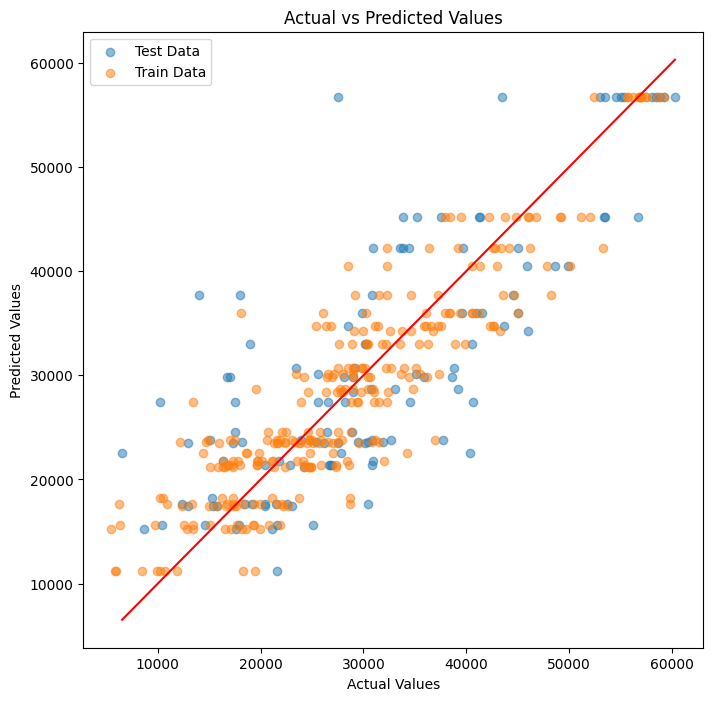

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test Data')
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train Data')

# Add a line for perfect prediction
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test, 1))(np.unique(y_test)), color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

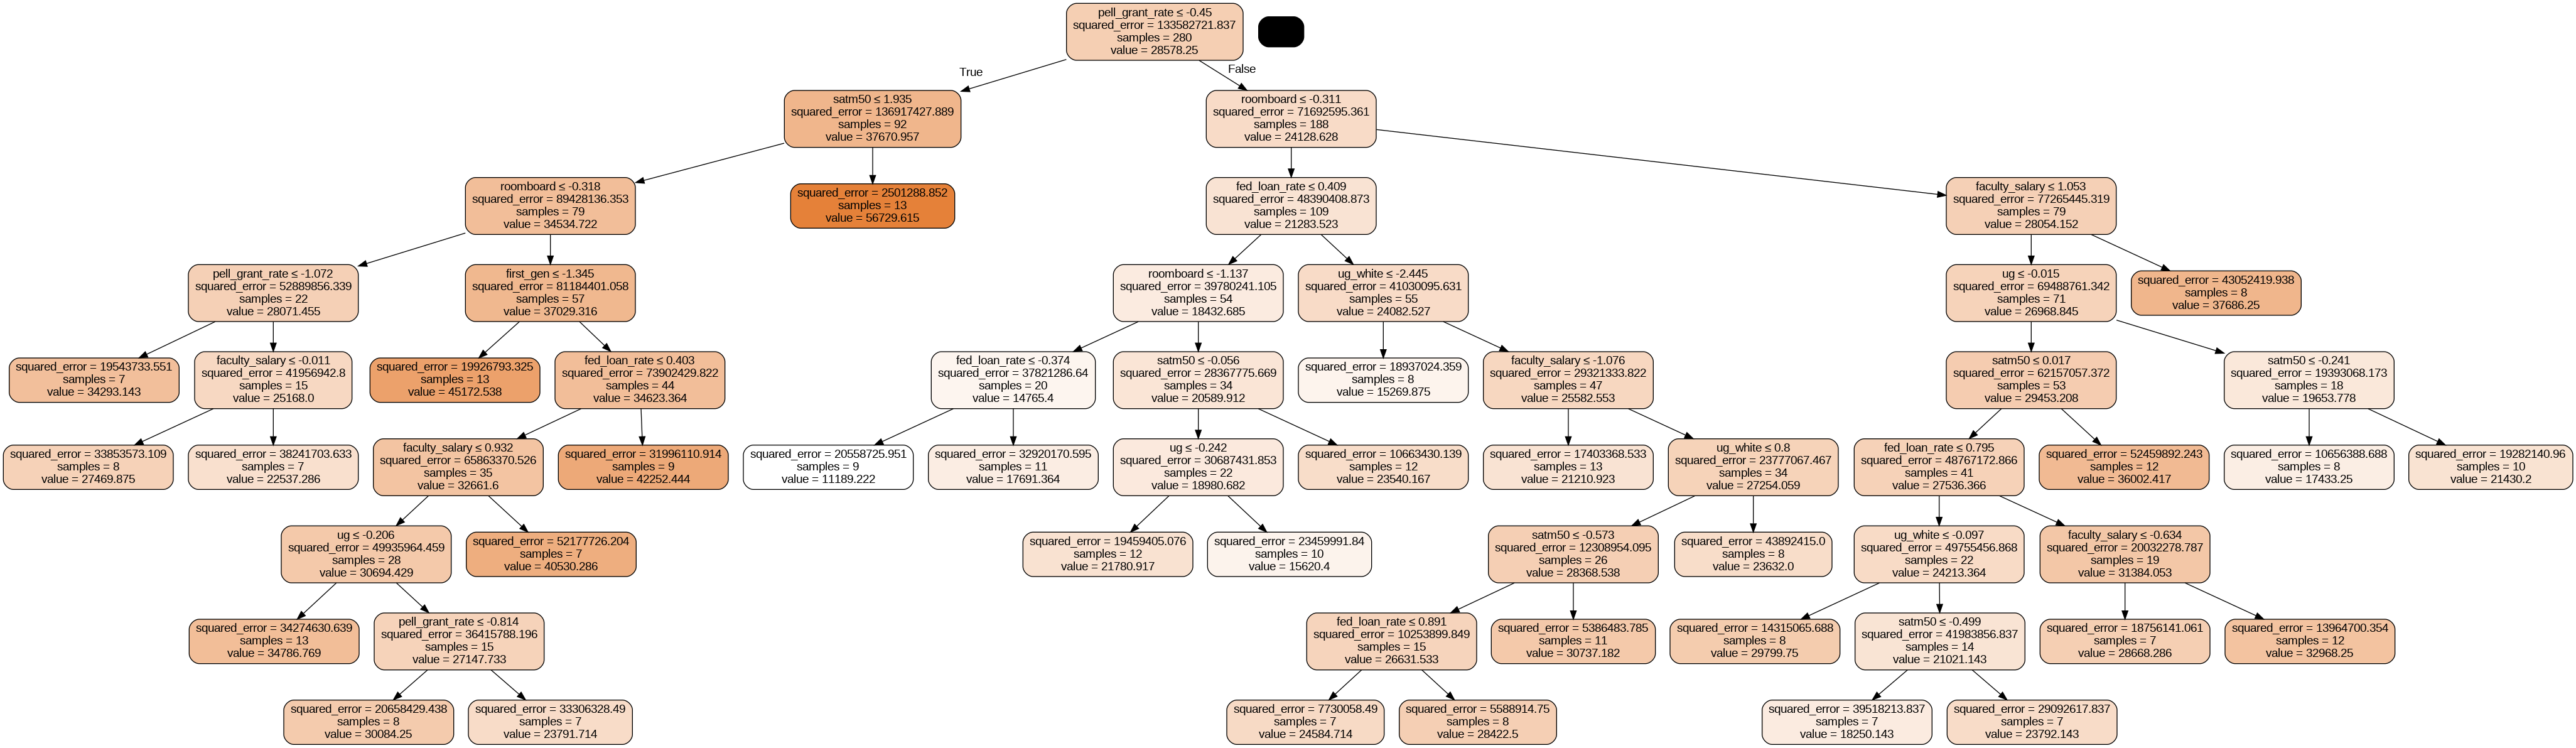

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# Assuming you have already trained your Decision Tree Regressor model and it's named as 'regressor'
dot_data = StringIO()

# Assuming 'feature_cols' is a list of your feature names
export_graphviz(best_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
warnings.filterwarnings('ignore')
colleges=pd.read_csv("colleges_train.csv")
features = ["adm_rate", "satm50", "pell_grant_rate", "fed_loan_rate", "ug",
            "ug_men",
            "ug_white", "ug_black", "ug_hispanic", "ug_asian", "ug_25plus", "first_gen", "math_deg",
            "faculty_salary", "engi_deg", "bio_deg", "sci_deg", "human_deg", "psych_deg", "engl_deg", "edu_deg",
            "foreign_lang_deg", "law_deg", "comm_deg", "compsci_deg", "arch_deg", "agri_deg", "hist_deg", "socialsci_deg",
            "health_deg", "business_deg", "ft_faculty_rate", "endowment", "booksupply", "roomboard"]
features = ["satm50", "pell_grant_rate", "fed_loan_rate", "ug", "first_gen", "faculty_salary", "ug_white", "socialsci_deg", "roomboard"]
x = colleges[features]
y = colleges["tuition"]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
#scaling the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Fitting Random Forest Regression to the dataset
#Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 7, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

best_estimator = grid_search.best_estimator_
# Use the best estimator for predictions
best_estimator.fit(x_train, y_train)
y_pred = best_estimator.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
# Evaluating the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean of Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Fitting 7 folds for each of 45 candidates, totalling 315 fits
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Root Mean of Squared Error: 6479.620380978202
R-squared: 0.7455327679495902


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Instantiate Random Forest Regressor
rf = RandomForestRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=100, cv=7, n_jobs=-1, verbose=2, random_state=1)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)

# Use the best estimator for predictions
best_estimator_random = random_search.best_estimator_
best_estimator_random.fit(x_train, y_train)
y_pred_random = best_estimator_random.predict(x_test)

# Evaluate the model
mse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
print(f'Root Mean of Squared Error with RandomizedSearchCV: {mse_random}')


Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 40}
Root Mean of Squared Error with RandomizedSearchCV: 6468.737108830872


***DAVID's CODE***

In [ ]:
data_raw = pd.read_csv("./colleges_train.csv")

data_raw = data_raw.drop(['name', 'state', 'satm25', 'satm75', 'satv25', 'satv50', 'satv75','ug_women'], axis=1)

data_std = (data_raw - data_raw.mean()) / data_raw.std()

data = data_raw.copy()

y = data['tuition']

data = data.drop(['tuition'], axis=1)

# data = (data - data.mean()) / data.std()

features1 = [
             'adm_rate', 'endowment', 'faculty_salary', 'ft_faculty_rate',
             'fed_loan_rate',
             'pell_grant_rate',
             'roomboard',
             'socialsci_deg',
             'satm50',
             'ug', 'ug_25plus', 'first_gen',
             'ug_white', 'ug_black',
             'ug_asian',
             ]
data_trim1 = data[features1].copy()


features2 = [
            #  'adm_rate',
             'endowment', 'faculty_salary',
            #  'ft_faculty_rate',
             'fed_loan_rate',
             'pell_grant_rate',
             'roomboard',
            #  'socialsci_deg',
             'satm50',
             'ug', 'ug_25plus',
            #  'first_gen',
            #  'ug_white', 'ug_black',
             'ug_asian',
             ]
data_trim2 = data[features2].copy()


Num input features: 35



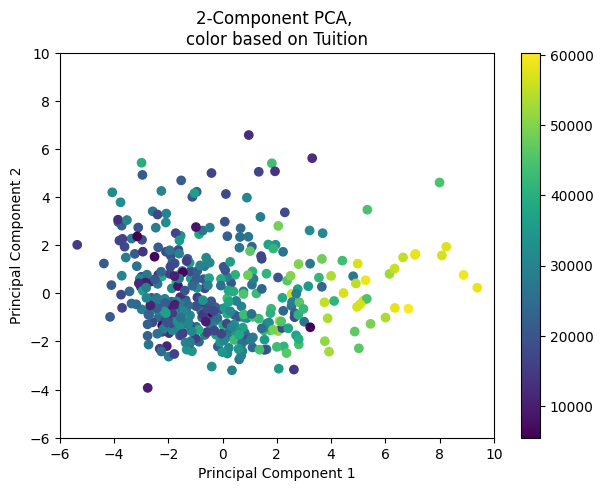

,pc1,pc2
count,4.000000e+02,4.000000e+02
mean,3.552714e-17,5.329071e-17
std,2.638183e+00,1.796963e+00
min,-5.357426e+00,-3.928685e+00
25%,-1.871137e+00,-1.286831e+00
50%,-5.368708e-01,-4.023839e-01
75%,1.344457e+00,9.373439e-01
max,1.147149e+01,6.578633e+00


In [ ]:
pickData = 0
##########################
if pickData == 0:
    X = data.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Full Data'
elif pickData == 1:
    X = data_trim1.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Trimmed Data v1'
elif pickData == 2:
    X = data_trim2.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Trimmed Data v2'
else:
    print('Invalid Data Selection')

print(f"Num input features: {X.shape[1]}\n")

pca = PCA() # n_components=X.shape[1]
pca = PCA(n_components=0.95)
pca = PCA(n_components=2)

pca.fit(X)
PC = pca.fit_transform(X)
p_Df = pd.DataFrame(data = PC
             , columns = ['pc1', 'pc2'])
p_Df.head()

plt.figure(figsize=(7, 5))
# plt.grid(True)
plt.scatter(p_Df['pc1'], p_Df['pc2'],c=y)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-6, 10)
plt.ylim(-6, 10)
plt.title(f'2-Component PCA, \ncolor based on Tuition')
# plt.legend()
plt.show()

p_Df.describe()


Num input features: 19

Gradient Boosting Model, Tirth

Single Run
RMSE Train: 2,684.188
RMSE Test:  5,739.996
R² Test:    0.808

K-folds = 7, Mean of Results
RMSE Train: 2,743.192
RMSE Test:  5,860.878
R² Test:    0.799

Baseline
RMSE Base: 13,086.661


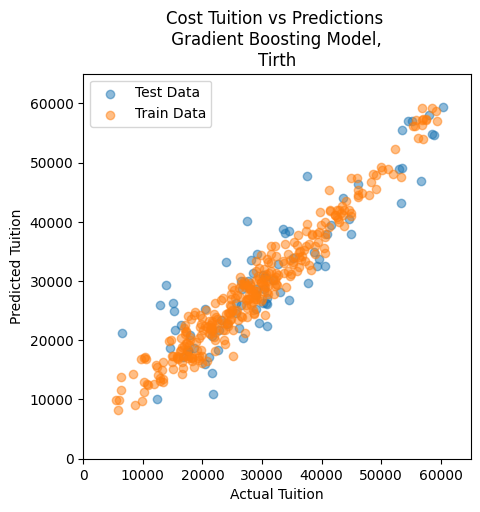

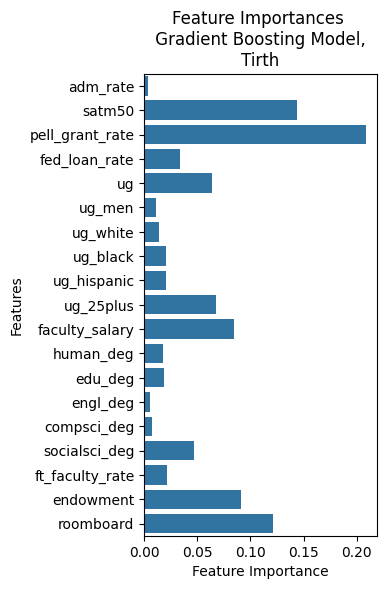

In [ ]:
pickData = 3
##########################
if pickData == 0:
    X = data.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Full Data'
elif pickData == 1:
    X = data_trim1.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Trimmed Data v1'
elif pickData == 2:
    X = data_trim2.copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Trimmed Data v2'
elif pickData == 3:
    features = [
            'adm_rate',
            'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
            'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
            'faculty_salary', 'human_deg', 'edu_deg',
            # 'foreign_lang_deg',
            'engl_deg',
            'compsci_deg',
            # 'law_deg',
            # 'hist_deg',
            'socialsci_deg', 'ft_faculty_rate', 'endowment', 'roomboard']
    X = data[features].copy()
    X = (X - X.mean()) / X.std()
    dataType = 'Tirth'
else:
    print('Invalid Data Selection')


print(f"Num input features: {X.shape[1]}\n")

pickModel = 7
##########################
if pickModel == 0:
    model = LinearRegression()
    modelType = 'Linear'
elif pickModel == 1:
    model = Ridge(alpha=1.0)
    modelType = 'Ridge'
elif pickModel == 2:
    model = Lasso()
    modelType = 'Lasso'
elif pickModel == 3:
    model = SGDRegressor()
    modelType = 'SGD'
elif pickModel == 4:
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
    model = QuantileRegressor(quantile=0.5, solver=solver)
    modelType = 'Quantile'
elif pickModel == 7:

    common_params = { 'max_depth': 2, 'n_estimators': 200, 'max_features': 7}

    # model = GradientBoostingRegressor(n_estimators=100, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='squared_error')
    # model = GradientBoostingRegressor(n_estimators=50, loss='squared_error', random_state=1)
    # model = GradientBoostingRegressor(n_estimators=300, max_depth=1, loss='squared_error', random_state=1,)
    model = GradientBoostingRegressor(loss="squared_error", random_state=10, **common_params,  ) # loss="quantile",
    # model = GradientBoostingRegressor(random_state=1)
    # model = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=10, **common_params, ) # loss="quantile",

    modelType = 'Gradient Boosting'

elif pickModel == 8:
    model = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=1)
    modelType = 'Random Forest'
else:
    print('Invalid Model Selection')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the mean squared error of the model on the training and testing data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# r2 = r2_score(y_train, y_train_pred)

# calculate the baseline mse
baseline = np.mean(y)
baseline_rmse = np.sqrt(np.mean((y_test - y_train.mean()) ** 2))


nfolds = 7
kfolds = KFold(n_splits=nfolds,random_state=1,shuffle=True)
# scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfolds))
cross_val = cross_validate(model, X, y, scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True, cv=kfolds)
cross_val_train_rmse = np.sqrt(-cross_val['train_score'])
cross_val_test_rmse = np.sqrt(-cross_val['test_score'])

print(f'{modelType} Model, {dataType}\n')
print('Single Run')
print(f'RMSE Train: {rmse_train:,.3f}')
print(f'RMSE Test:  {rmse_test:,.3f}')
# print(f'R² Train:         {1 - rmse_train.mean()**2 / baseline_rmse**2:,.3f}')
print(f'R² Test:    {1 - rmse_test.mean()**2 / baseline_rmse**2:,.3f}')

print(f'\nK-folds = {nfolds}, Mean of Results')
print(f'RMSE Train: {cross_val_train_rmse.mean():,.3f}')  # scores.mean()
print(f'RMSE Test:  {cross_val_test_rmse.mean():,.3f}')   # scores.mean()
print(f'R² Test:    {1 - cross_val_test_rmse.mean()**2 / baseline_rmse**2:,.3f}')
# print(f'RMSE StDev:   {scores.std():,.3f}')
# print(f'\nRMSE Scores: ')
# print(np.sqrt(-cross_val['test_score']))

print('\nBaseline')
print(f'RMSE Base: {baseline_rmse:,.3f}')

# calculate r² score of cross_val_test_rmse

# generate average feature importances for each item in the cross_val
# feature_importances = np.zeros(X.shape[1])
# for i in range(nfolds):
#     feature_importances += cross_val['estimator'][i].feature_importances_
# feature_importances /= nfolds
# print(f'\nFeature Importances: {feature_importances}')

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5,label='Test Data')
plt.scatter(y_train, y_train_pred, alpha=0.5,label='Train Data')
plt.xlim(0, 65000)
plt.ylim(0, 65000)
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition')
plt.title(f'Cost Tuition vs Predictions \n {modelType} Model, \n{dataType}')
plt.legend()

# Plot the feature importances of the model
plt.figure(figsize=(3, 6))

if modelType in ['Linear', 'Ridge', 'Lasso', 'SGD']:
    sns.barplot(x=model.coef_, y=X.columns)
    # print(f'\n Coef: {np.around(model.coef_,3)}')
if modelType in ['Gradient Boosting', 'Random Forest']:
    sns.barplot(x=model.feature_importances_, y=X.columns)
    # sns.barplot(x=feature_importances, y=X.columns)
    # print(f'\n Coef: {np.around(model.feature_importances_,4)}')


plt.title(f'Feature Importances \n {modelType} Model, \n{dataType}')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

# order coefficients and columns by absolute values and print them
if modelType in ['Linear', 'Ridge', 'Lasso', 'SGD']:
    beta_best_abs = np.abs(model.coef_)
    beta_best_order = np.argsort(beta_best_abs)[::-1]
    beta_best = model.coef_[beta_best_order]
    X_columns = X.columns[beta_best_order]
    # print the ordered coefficients and names
    print("Ordered Coefficients: ")
    for i in range(X_columns.size):
        print(f"{X_columns[i]}: {beta_best[i]:.2f}")

Num input features: 19

Train Pred < 10% Q : 2
Train Pred > 90% Q : 0
Test  Pred < 10% Q : 1
Test  Pred > 90% Q : 4


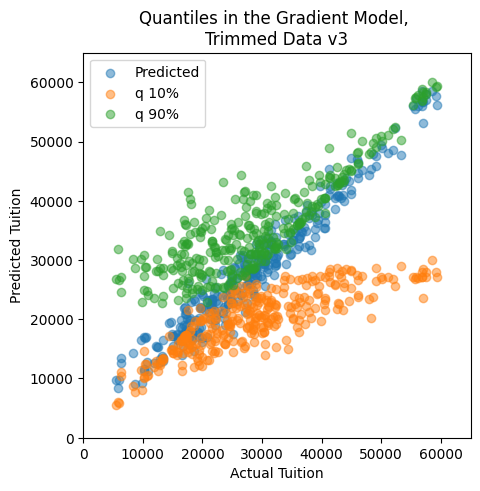

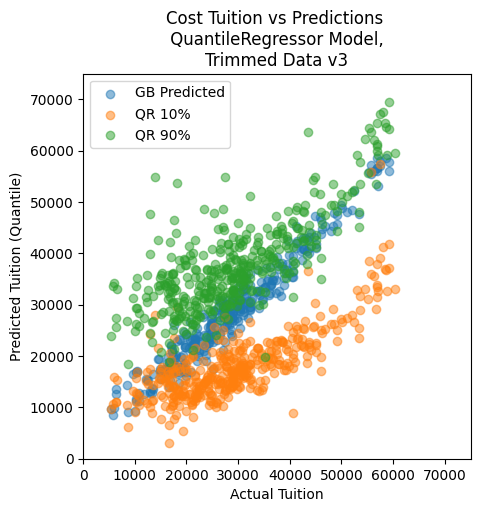

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html


pickData = 3
##########################
if pickData == 0:
    X1 = data.copy()
    X = (X1 - X1.mean()) / X1.std()
    dataType = 'Full Data'
elif pickData == 1:
    X1 = data_trim1.copy()
    X = (X1 - X1.mean()) / X1.std()
    dataType = 'Trimmed Data v1'
elif pickData == 2:
    X1 = data_trim2.copy()
    X = (X1 - X1.mean()) / X1.std()
    dataType = 'Trimmed Data v2'
elif pickData == 3:
    features = [
            'adm_rate',
            'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
            'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
            'faculty_salary', 'human_deg', 'edu_deg',
            # 'foreign_lang_deg',
            'engl_deg',
            'compsci_deg',
            # 'law_deg',
            # 'hist_deg',
            'socialsci_deg', 'ft_faculty_rate', 'endowment', 'roomboard']
    X1 = data[features].copy()
    X = (X1 - X1.mean()) / X1.std()
    dataType = 'Trimmed Data v3'

else:
    print('Invalid Data Selection')

print(f"Num input features: {X.shape[1]}\n")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#Print size of training and testing data
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

all_models = {}
# common_params = { 'max_depth': 1, 'n_estimators': 300,}

for alpha in [0.10, 0.90]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

y_pred = all_models["mse"].predict(X_train)
y_lower = all_models["q 0.10"].predict(X_train)
y_upper = all_models["q 0.90"].predict(X_train)
# y_med = all_models["q 0.50"].predict(X_train)

y_pred_test = all_models["mse"].predict(X_test)
y_lower_test = all_models["q 0.10"].predict(X_test)
y_upper_test = all_models["q 0.90"].predict(X_test)

# create a dataframe of y_lower, y_pred, y_upper
df_train = pd.DataFrame({'y_train': y_train, 'y_lower': y_lower, 'y_pred': y_pred, 'y_upper': y_upper})
df_train = df_train.round(0)

df_test = pd.DataFrame({'y_test': y_test, 'y_lower': y_lower_test, 'y_pred': y_pred_test, 'y_upper': y_upper_test})
df_test = df_test.round(0)

print(f'Train Pred < 10% Q : {len(df_train[y_pred<y_lower])}')
print(f'Train Pred > 90% Q : {len(df_train[y_pred>y_upper])}')

print(f'Test  Pred < 10% Q : {len(df_test[y_pred_test<y_lower_test])}')
print(f'Test  Pred > 90% Q : {len(df_test[y_pred_test>y_upper_test])}')

# create a scatter plot of of y_train vs y_pred
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, alpha=0.5, label='Predicted')
plt.scatter(y_train, y_lower, alpha=0.5, label='q 10%')
plt.scatter(y_train, y_upper, alpha=0.5, label='q 90%')
# plt.scatter(y_train, y_med, alpha=0.5)
plt.legend()
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition')
plt.title(f'Quantiles in the Gradient Model, \n{dataType}')
plt.xlim(0, 65000)
plt.ylim(0, 65000)
plt.show()



# the two following lines are optional in practice
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
reg = QuantileRegressor(quantile=0.9, solver=solver).fit(X1, y)
y_pred_90 = reg.predict(X1)
y_pred_90

reg = QuantileRegressor(quantile=0.1, solver=solver).fit(X1, y)
y_pred_10 = reg.predict(X1)
y_pred_10
modelType = "QuantileRegressor"


plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, alpha=0.5, label='GB Predicted')
plt.scatter(y, y_pred_10, alpha=0.5,label='QR 10%')
plt.scatter(y, y_pred_90, alpha=0.5,label='QR 90%')
plt.xlim(0, 75000)
plt.ylim(0, 75000)
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition (Quantile)')
plt.title(f'Cost Tuition vs Predictions \n {modelType} Model, \n{dataType}')
plt.legend()
plt.show()


In [ ]:
data_final = pd.read_csv("./colleges_test_features.csv")
# data_final = data_final.drop(['state', 'satm25', 'satm75', 'satv25', 'satv50', 'satv75','ug_women'], axis=1)

features = [
        'adm_rate',
        'satm50', 'pell_grant_rate', 'fed_loan_rate', 'ug',
        'ug_men', 'ug_white', 'ug_black', 'ug_hispanic', 'ug_25plus',
        'faculty_salary', 'human_deg', 'edu_deg',
        # 'foreign_lang_deg',
        'engl_deg',
        'compsci_deg',
        # 'law_deg',
        # 'hist_deg',
        'socialsci_deg', 'ft_faculty_rate', 'endowment', 'roomboard']

X1 = data_final[features].copy()
X = (X1 - X1.mean()) / X1.std()

y_pred_final = all_models["mse"].predict(X)
y_lower_final = all_models["q 0.10"].predict(X)
y_upper_final = all_models["q 0.90"].predict(X)

df_results = pd.DataFrame({'y_pred': y_pred_final, 'y_10%': y_lower_final, 'y_90%': y_upper_final,})


print(f'Train Pred < 10% Q : {len(df_results[y_pred_final<y_lower_final])}')
print(f'Train Pred > 90% Q : {len(df_results[y_pred_final>y_upper_final])}')

# df_results = pd.DataFrame({'y_lower': y_lower_final, 'y_pred': y_pred_final, 'y_upper': y_upper_final})
df_results = df_results.round(0)
df_results.head()
df_results.to_csv('colleges_test_predictions.csv', index=False)

Train Pred < 10% Q : 37
Train Pred > 90% Q : 21


Num input features: 35

Best Parameters: {'max_depth': 4, 'max_features': 9, 'n_estimators': 200}
QuantileRegressor Model, Full Data

Single Run
RMSE Train: 340.811
RMSE Test:  6,381.900
R² Test:    0.762
Best Hyperparameters:
max_depth: 4
max_features: 9
n_estimators: 200


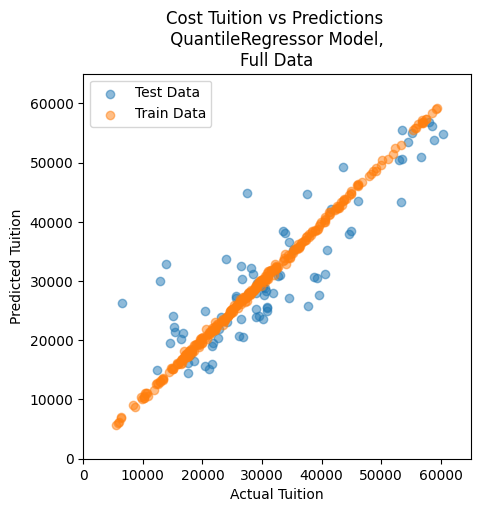

In [ ]:

pickData = 0
##########################
if pickData == 0:
    X = data.copy()
    dataType = 'Full Data'
elif pickData == 1:
    X = data_trim1.copy()
    dataType = 'Trimmed Data v1'
elif pickData == 2:
    X = data_trim2.copy()
    dataType = 'Trimmed Data v2'
else:
    print('Invalid Data Selection')

print(f"Num input features: {X.shape[1]}\n")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define the parameter grid for cross-validation
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    # 'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5],
    'max_features': [5, 7, 9]
}

# Perform GridSearchCV to find the best hyperparameters
gb_regressor_cv = GridSearchCV(estimator=GradientBoostingRegressor(random_state=1),
                               param_grid=param_grid,
                               scoring='neg_root_mean_squared_error',
                               cv=7)



gb_regressor_cv.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_gb_regressor = gb_regressor_cv.best_estimator_
best_params = gb_regressor_cv.best_params_

print("Best Parameters:", best_params)


# Train the best model on the entire training set
best_gb_regressor.fit(X_train, y_train)



# Predict the target variable on the training and testing data
y_train_pred = best_gb_regressor.predict(X_train)
y_test_pred = best_gb_regressor.predict(X_test)

# Calculate the mean squared error of the model on the training and testing data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# r2 = r2_score(y_train, y_train_pred)

# calculate the baseline mse
baseline = np.mean(y)
baseline_rmse = np.sqrt(np.mean((y_test - y_train.mean()) ** 2))


print(f'{modelType} Model, {dataType}\n')
print('Single Run')
print(f'RMSE Train: {rmse_train:,.3f}')
print(f'RMSE Test:  {rmse_test:,.3f}')
# print(f'R² Train:         {1 - rmse_train.mean()**2 / baseline_rmse**2:,.3f}')
print(f'R² Test:    {1 - rmse_test.mean()**2 / baseline_rmse**2:,.3f}')


plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5,label='Test Data')
plt.scatter(y_train, y_train_pred, alpha=0.5,label='Train Data')
plt.xlim(0, 65000)
plt.ylim(0, 65000)
plt.xlabel('Actual Tuition')
plt.ylabel('Predicted Tuition')
plt.title(f'Cost Tuition vs Predictions \n {modelType} Model, \n{dataType}')
plt.legend()

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
